# Libraries

In [5]:
import os
from datetime import datetime
from datetime import timedelta
import shutil
from scipy.stats.mstats import gmean
from scipy.stats import entropy
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter
import glob
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
import seaborn as sns

# Data Transformer

In [6]:
import numpy as np


class Transformer:

    def __init__(self, decision_size, decision_overlap, segments_size=90, segments_overlap=45, sampling=2):
        self.segments_size = segments_size
        self.segments_overlap = segments_overlap
        self.sampling = sampling
        self.decision_size = decision_size
        self.decision_overlap = decision_overlap

    def transfer(self, dataset, features, method):
        print("segmenting data with " + str(len(dataset)) + " points")
        segments, labels = self.__segment_signal(dataset, features)
        print("making " + str(len(segments)) + " segments")
        if method == "table":
            segments_dataset = self.__transfer_table(segments, features)
        elif method == "1d":
            segments_dataset = self.__transfer_1d(segments, features)
        elif method == "2d":
            segments_dataset = self.__transfer_2d(segments, features)
        elif method == "3d_1ch":
          segments_dataset = self.__transfer_2d_1ch(segments, features)
        elif method == "3d":
            segments_dataset = self.__transfer_3d(segments, features)
        elif method == "4d":
            segments_dataset = self.__transfer_4d(segments, features)
        elif method == "rnn_2d":
            segments_dataset, labels =  self.__transfer_rnn_2d(segments, labels, features)
        elif method == "rnn_3d_1ch":
            segments_dataset, labels =  self.__transfer_rnn_3d_1ch(segments, labels, features)
        return segments_dataset, labels

    @staticmethod
    def data_shape(method, n_features, segments_size, segments_overlap=None, decision_size=None):
        if method == "table":
            return (None, n_features * segments_size)
        elif method == "1d":
            return (None, 1, n_features * segments_size, 1)
        elif method == "2d":
            return (None, n_features, segments_size)
        elif method == "3d_1ch":
            return (None, n_features, segments_size, 1)
        elif method == "3d":
            return (None, 1, segments_size, n_features)
        elif method == "4d":
            return (n_features, None, 1, segments_size, 1)
        elif method == "rnn_2d":
            s_b = Transformer.get_segments_a_decision_window(segments_size,
                                                             int(segments_size * segments_overlap),
                                                             decision_size)
            return (None, s_b, segments_size*n_features)
        elif method == "rnn_3d_1ch":
            s_b = Transformer.get_segments_a_decision_window(segments_size,
                                                             int(segments_size * segments_overlap),
                                                             decision_size)
            return (None, s_b, 1, segments_size*n_features)
        return ()

    @staticmethod
    def get_segments_a_decision_window(segment_size, segment_overlap_size, decision_size):
        return int((decision_size - segment_size) / (segment_size - segment_overlap_size) + 1)

    def __transfer_rnn_2d(self, segments, labels, features):
        y_output = []
        x_output = []
        c = len(np.unique(labels))
        s = Transformer.get_segments_a_decision_window(self.segments_size,
                                                       self.segments_overlap,
                                                       self.decision_size)
        r = int(np.floor(s * self.decision_overlap))
        for _id in np.unique(labels):
          subset = segments[np.where(labels == _id)]
          n = subset.shape[0]
          o = int(np.floor((n - r) / (s - r)))
          for i in range(o):
            row = []
            for j in range(s):
              A = subset[i * (s-r) + j]
              A = A.reshape(A.shape[0]*A.shape[1])
              row.append(A)
            y_output.append(_id)
            x_output.append(row)
        x_output = np.array(x_output)
        y_output = np.array(y_output)
        return x_output, y_output

    def __transfer_rnn_3d_1ch(self, segments, labels, features):
        # (samples, time, channels=1, rows)
        y_output = []
        x_output = []
        c = len(np.unique(labels))
        s = Transformer.get_segments_a_decision_window(self.segments_size,
                                                       self.segments_overlap,
                                                       self.decision_size)
        r = int(np.floor(s * self.decision_overlap))
        for _id in np.unique(labels):
          subset = segments[np.where(labels == _id)]
          n = subset.shape[0]
          o = int(np.floor((n - r) / (s - r)))
          for i in range(o):
            row = []
            for j in range(s):
              A = subset[i * (s-r) + j]
              A = A.reshape(A.shape[0]*A.shape[1])
              row.append([A])
            y_output.append(_id)
            x_output.append(row)
        x_output = np.array(x_output)
        y_output = np.array(y_output)
        return x_output, y_output

    def __transfer_table(self, segments, features):
        new_dataset = []
        for segment in segments:
            row = []
            for feature_i in range(len(features)):
                for i in range(len(segment[feature_i])):
                    row.append(segment[feature_i][i])
            new_dataset.append(row)

        new_dataset = np.array(new_dataset)
        return new_dataset

    def __transfer_1d(self, segments, features):
        new_dataset = []
        for segment in segments:
            row = []
            for feature_i in range(len(features)):
                for i in range(len(segment[feature_i])):
                    row.append(segment[feature_i][i])
            new_dataset.append([row])

        new_dataset = np.array(new_dataset)
        return np.expand_dims(new_dataset, axis=3)

    def __transfer_2d(self, segments, features):
        new_dataset = []
        for segment in segments:
            row = []
            for feature_i in range(len(features)):
                row.append(segment[feature_i])
            new_dataset.append(row)

        new_dataset = np.array(new_dataset)
        return new_dataset

    def __transfer_3d_1ch(self, segments, features):
        new_dataset = []
        for segment in segments:
            row = []
            for feature_i in range(len(features)):
                row.append(segment[feature_i])
            new_dataset.append(row)

        new_dataset = np.array(new_dataset)
        return np.expand_dims(new_dataset, axis=3)

    def __transfer_3d(self, segments, features):
        new_dataset = []
        for segment in segments:
            row = []
            for i in range(len(segment[0])):
                cell = []
                for feature_i in range(len(features)):
                    cell.append(segment[feature_i][i])
                row.append(cell)
            new_dataset.append([row])

        new_dataset = np.array(new_dataset)
        return new_dataset

    def __transfer_4d(self, segments, features):
        new_dataset = []
        for feature_i in range(len(features)):
            row = []
            for segment in segments:
                cell = []
                for element in segment[feature_i]:
                    cell.append([element])
                row.append([cell])
            new_dataset.append(row)

        new_dataset = np.array(new_dataset)
        return new_dataset

    def __windows(self, data):
        start = 0
        while start < data.count():
            yield int(start), int(start + self.segments_size)
            start += (self.segments_size - self.segments_overlap)

    def __segment_signal(self, dataset, features):
        segments = []
        labels = []
        for class_i in np.unique(dataset["id"]):
            subset = dataset[dataset["id"] == class_i]
            for (start, end) in self.__windows(subset["id"]):
                feature_slices = []
                for feature in features:
                    feature_slices.append(subset[feature][start:end].tolist())
                if len(feature_slices[0]) == self.segments_size:
                    segments.append(feature_slices)
                    labels.append(class_i)
        return np.array(segments), np.array(labels)


# Dataset

In [7]:
class Dataset:

    def __init__(self, db_path, sample_rate, features,
                 window_time, window_overlap_percentage,
                 decision_time, decision_overlap_percentage,
                 add_noise, noise_rate,
                 label_noise_rate,
                 train_blocks: list, valid_blocks: list, test_blocks: list,
                 data_length_time=-1):
        """
        :param db_path:
        :param sample_rate:
        :param features:
        :param window_time: in seconds
        :param window_overlap_percentage: example: 0.75 for 75%
        :param add_noise: True or False
        :param noise_rate:
        :param train_blocks:
        :param valid_blocks:
        :param test_blocks:
        :param data_length_time: the amount of data from each class in seconds. -1 means whole existing data.
        """
        self.db_path = db_path
        self.features = features
        self.sample_rate = sample_rate
        self.window_size = window_time * sample_rate
        self.window_overlap_size = int(self.window_size * window_overlap_percentage)
        self.decision_size = decision_time * sample_rate
        self.decision_overlap_size = int(self.decision_size * decision_overlap_percentage)
        self.decision_overlap_percentage = decision_overlap_percentage
        self.add_noise = add_noise
        self.noise_rate = noise_rate
        self.label_noise_rate = label_noise_rate
        self.train_blocks = train_blocks
        self.valid_blocks = valid_blocks
        self.test_blocks = test_blocks
        self.data_length_size = data_length_time * sample_rate if data_length_time != -1 else -1

        # Initialization
        self.train_dataset = pd.DataFrame()
        self.valid_dataset = pd.DataFrame()
        self.test_dataset = pd.DataFrame()
        self.n_train_dataset = pd.DataFrame()
        self.n_valid_dataset = pd.DataFrame()
        self.n_test_dataset = pd.DataFrame()
        self.X_train = np.array([])
        self.y_train = np.array([])
        self.X_valid = np.array([])
        self.y_valid = np.array([])
        self.X_test = np.array([])
        self.y_test = np.array([])

    def load_data(self, n_classes, method, subset=None, read_cache=True, random_selection=True):
        segments_path = self.db_path + \
                        "segments/" + \
                        "method " + str(method) + os.sep + \
                        "noise " + str(self.noise_rate) + os.sep + \
                        "n_classes " + str(n_classes) + os.sep + \
                        "wl " + str(self.window_size) + os.sep + \
                        "wo " + str(self.window_overlap_size) + os.sep + \
                        "dl " + str(self.decision_size) + os.sep + \
                        "do " + str(self.decision_overlap_size) + os.sep + \
                        "train " + str(self.train_blocks) + os.sep + \
                        "valid " + str(self.valid_blocks) + os.sep + \
                        "test " + str(self.test_blocks) + os.sep
        
        print(segments_path)
        if read_cache \
                and os.path.exists(segments_path + 'X_train.npy') \
                and os.path.exists(segments_path + 'y_train.npy') \
                and os.path.exists(segments_path + 'X_valid.npy') \
                and os.path.exists(segments_path + 'y_valid.npy') \
                and os.path.exists(segments_path + 'X_test.npy') \
                and os.path.exists(segments_path + 'y_test.npy'):
            print("Dataset is already")
            self.X_train = np.load(segments_path + 'X_train.npy')
            self.y_train = np.load(segments_path + 'y_train.npy')
            self.X_valid = np.load(segments_path + 'X_valid.npy')
            self.y_valid = np.load(segments_path + 'y_valid.npy')
            self.X_test = np.load(segments_path + 'X_test.npy')
            self.y_test = np.load(segments_path + 'y_test.npy')
        else:
            self.__preprocess(n_classes, method, subset, random_selection)
            # Save Dataset
            if not os.path.exists(segments_path):
                os.makedirs(segments_path)
            np.save(segments_path + 'X_train.npy', self.X_train)
            np.save(segments_path + 'y_train.npy', self.y_train)
            np.save(segments_path + 'X_valid.npy', self.X_valid)
            np.save(segments_path + 'y_valid.npy', self.y_valid)
            np.save(segments_path + 'X_test.npy', self.X_test)
            np.save(segments_path + 'y_test.npy', self.y_test)

        def to_dic(data):
            dic = {}
            for i, x in enumerate(data):
                dic[str(i)] = x
            return dic

        if len(self.X_train.shape) == 5:
            self.X_train = to_dic(self.X_train)
            self.X_valid = to_dic(self.X_valid)
            self.X_test = to_dic(self.X_test)

    def __preprocess(self, n_classes, method, subset=None, random_selection=True):
        if random_selection:
            csv_paths = np.random.choice(glob.glob(self.db_path + "*.csv"), n_classes, replace=False)
        else:
            csv_paths = glob.glob(self.db_path + "*.csv")[:n_classes]

        self.class_names = {}
        for i, csv_path in enumerate(csv_paths):
            label = os.path.basename(csv_path).split('.')[0]
            self.class_names[label] = i
            train, valid, test = self.__read_data(csv_path, self.features, label, subset)
            train['id'] = i
            valid['id'] = i
            test['id'] = i

            def flip_labels(labels, num_classes, flip_percentage):
                num_samples = labels.shape[0]
                num_flips = int(num_samples * flip_percentage)

                # Randomly select indices to flip
                flip_indices = np.random.choice(num_samples, num_flips, replace=False)
                # print(flip_indices)

                # Generate new random labels for flipped indices
                new_labels = np.random.randint(0, num_classes, num_flips)

                # Update the labels with flipped values
                labels[flip_indices] = new_labels

                return labels

            if self.label_noise_rate > 0:
                train['id'] = flip_labels(train['id'].to_numpy(), len(csv_paths), self.label_noise_rate)


            self.train_dataset = pd.concat([self.train_dataset, train])
            self.valid_dataset = pd.concat([self.valid_dataset, valid])
            self.test_dataset = pd.concat([self.test_dataset, test])

        self.__standardization()
        self.__segmentation(method=method)

    def __read_data(self, path, features, label, subset=None):
        data = pd.read_csv(path, low_memory=False)
        if subset != None:
            data = data.loc[ data['activity'].isin(subset) ]
        data = data[features]
        data = data.fillna(data.mean())

        length = self.data_length_size if self.data_length_size != -1 else data.shape[0]
        print('class: %5s, data size: %s, selected data size: %s' % (
            label, str(timedelta(seconds=int(data.shape[0] / self.sample_rate))),
            str(timedelta(seconds=int(length / self.sample_rate)))))
        return self.__split_to_train_valid_test(data)

    def __split_to_train_valid_test(self, data):
        n_blocks = max(self.train_blocks + self.valid_blocks + self.test_blocks) + 1
        block_length = int(len(data[:self.data_length_size]) / n_blocks)

        train_data = pd.DataFrame()
        for i in range(len(self.train_blocks)):
            start = self.train_blocks[i] * block_length
            end = self.train_blocks[i] * block_length + block_length - 1
            if train_data.empty:
                train_data = data[start:end]
            else:
                train_data = pd.concat([data[start:end], train_data])

        valid_data = pd.DataFrame()
        for i in range(len(self.valid_blocks)):
            start = self.valid_blocks[i] * block_length
            end = self.valid_blocks[i] * block_length + block_length - 1
            if valid_data.empty:
                valid_data = data[start:end]
            else:
                valid_data = pd.concat([data[start:end], valid_data])

        test_data = pd.DataFrame()
        for i in range(len(self.test_blocks)):
            start = self.test_blocks[i] * block_length
            end = self.test_blocks[i] * block_length + block_length - 1
            if test_data.empty:
                test_data = data[start:end]
            else:
                test_data = pd.concat([data[start:end], test_data])

        if self.add_noise:
            test_data = self.__add_noise_to_data(test_data)

        return train_data, valid_data, test_data

    def __add_noise_to_data(self, x):
        x_power = x ** 2
        sig_avg_watts = np.mean(x_power)
        sig_avg_db = 10 * np.log10(sig_avg_watts)
        noise_avg_db = sig_avg_db - self.target_snr_db
        noise_avg_watts = 10 ** (noise_avg_db / 10)
        mean_noise = 0
        noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), size=x.shape)
        return x + noise_volts

    def __standardization(self):
        scaler = preprocessing.StandardScaler()
        scaler = scaler.fit(self.train_dataset.iloc[:, :-1])
        n_train_dataset = scaler.transform(self.train_dataset.iloc[:, :-1])
        n_valid_dataset = scaler.transform(self.valid_dataset.iloc[:, :-1])
        n_test_dataset = scaler.transform(self.test_dataset.iloc[:, :-1])

        self.n_train_dataset = pd.DataFrame(n_train_dataset, columns=self.features)
        self.n_valid_dataset = pd.DataFrame(n_valid_dataset, columns=self.features)
        self.n_test_dataset = pd.DataFrame(n_test_dataset, columns=self.features)
        self.n_train_dataset['id'] = self.train_dataset.iloc[:, -1].tolist()
        self.n_valid_dataset['id'] = self.valid_dataset.iloc[:, -1].tolist()
        self.n_test_dataset['id'] = self.test_dataset.iloc[:, -1].tolist()

    def __segmentation(self, method):
        transformer = Transformer(segments_size=self.window_size,
                                  segments_overlap=self.window_overlap_size,
                                  decision_size=self.decision_size,
                                  decision_overlap=self.decision_overlap_percentage)
        self.X_train, self.y_train = transformer.transfer(self.n_train_dataset, self.features, method=method)
        self.X_valid, self.y_valid = transformer.transfer(self.n_valid_dataset, self.features, method=method)
        self.X_test, self.y_test = transformer.transfer(self.n_test_dataset, self.features, method=method)


# Dataset (DB2)

In [8]:
import numpy as np
import glob
import os
import random
from random import sample
from datetime import timedelta
import pandas as pd

class Dataset2(Dataset):

    def __init__(self, db_path, sample_rate, features,
                 window_time, window_overlap_percentage,
                 decision_time, decision_overlap_percentage,
                 add_noise, noise_rate,
                 label_noise_rate,
                 train_blocks: list, valid_blocks: list, test_blocks: list,
                 data_length_time=-1):
        self.w = window_time
        self.r = self.w - int(self.w * window_overlap_percentage)
        self.db_path = db_path
        self.X_train = np.array([])
        self.y_train = np.array([])
        self.X_valid = np.array([])
        self.y_valid = np.array([])
        self.X_test = np.array([])
        self.y_test = np.array([])

        self.window_size = window_time * sample_rate
        self.window_overlap_size = int(self.window_size * window_overlap_percentage)
        self.decision_size = decision_time * sample_rate
        self.decision_overlap_size = int(self.decision_size * decision_overlap_percentage)
        self.decision_overlap_percentage = decision_overlap_percentage
        self.add_noise = add_noise
        self.noise_rate = noise_rate
        self.label_noise_rate = label_noise_rate
        self.train_blocks = train_blocks
        self.valid_blocks = valid_blocks
        self.test_blocks = test_blocks
        self.data_length_size = data_length_time * sample_rate if data_length_time != -1 else -1
        self.features = features

    def load_data(self, n_classes, method):
        segments_path = self.db_path + \
                        "segments/" + \
                        "method " + str(method) + os.sep + \
                        "noise " + str(self.noise_rate) + os.sep + \
                        "n_classes " + str(n_classes) + os.sep + \
                        "wl " + str(self.window_size) + os.sep + \
                        "wo " + str(self.window_overlap_size) + os.sep + \
                        "dl " + str(self.decision_size) + os.sep + \
                        "do " + str(self.decision_overlap_size) + os.sep + \
                        "train " + str(self.train_blocks) + os.sep + \
                        "valid " + str(self.valid_blocks) + os.sep + \
                        "test " + str(self.test_blocks) + os.sep
        if os.path.exists(segments_path + 'X_train.npy') \
                and os.path.exists(segments_path + 'y_train.npy') \
                and os.path.exists(segments_path + 'X_valid.npy') \
                and os.path.exists(segments_path + 'y_valid.npy') \
                and os.path.exists(segments_path + 'X_test.npy') \
                and os.path.exists(segments_path + 'y_test.npy'):
            print("Dataset is already")
            self.X_train = np.load(segments_path + 'X_train.npy')
            self.y_train = np.load(segments_path + 'y_train.npy')
            self.X_valid = np.load(segments_path + 'X_valid.npy')
            self.y_valid = np.load(segments_path + 'y_valid.npy')
            self.X_test = np.load(segments_path + 'X_test.npy')
            self.y_test = np.load(segments_path + 'y_test.npy')
        else:
            y_signals = self.load_y(self.db_path+"train/y_train.txt")

            instances = len(y_signals)
            total = np.array([i for i in range(instances)])
            valids = sample([i for i in range(instances)], int(instances * 0.15))
            trains = np.delete(total, valids).tolist()

            self.X_train, self.y_train = self.load_X(self.db_path + "train/Inertial Signals/", y_signals, samples=trains, w=self.w, r=self.r)
            self.X_valid, self.y_valid = self.load_X(self.db_path + "train/Inertial Signals/", y_signals, samples=valids, w=self.w, r=self.r)

            y_signals = self.load_y(self.db_path + "test/y_test.txt")
            self.X_test, self.y_test = self.load_X(self.db_path + "test/Inertial Signals/", y_signals, w=self.w, r=self.r)

            # Save Dataset
            if not os.path.exists(segments_path):
                os.makedirs(segments_path)
            np.save(segments_path + 'X_train.npy', self.X_train)
            np.save(segments_path + 'y_train.npy', self.y_train)
            np.save(segments_path + 'X_valid.npy', self.X_valid)
            np.save(segments_path + 'y_valid.npy', self.y_valid)
            np.save(segments_path + 'X_test.npy', self.X_test)
            np.save(segments_path + 'y_test.npy', self.y_test)


    def windows(self, data, w, r):
        start = 0
        while start < len(data):
            yield int(start), int(start + w)
            start += (w - r)

    def segment_signal(self, X, y, w, r):
        X_new = []
        y_new = []
        for (start, end) in self.windows(X, w, r):
            segment = X[start:end]
            if len(segment) == w:
                X_new.append(segment)
                y_new.append(y)
        return np.array(X_new), np.array(y_new)

    def load_y(self, y_path):
        file = open(y_path, 'r')
        # Read dataset from disk, dealing with text file's syntax
        y_ = np.array(
            [elem for elem in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]],
            dtype=np.int32
        )
        file.close()
        return np.array(y_, dtype=np.int32)

    def load_X(self, path, y, samples=None, w=32, r=8):
        X_signals = []
        y_signals = []
        files = os.listdir(path)
        files.sort(key=str.lower)
        files = glob.glob(path + "*.txt")

        for fileName in files:
            print(fileName)
            file = open(fileName, 'r')
            X_container = []
            y_container = []

            for i, row in enumerate(file):
                if samples != None and i not in samples:
                    continue
                row = row.strip().replace('  ', ' ')
                X_i, y_i = self.segment_signal(row.strip().split(' '), y=y[i][0], w=w, r=r)
                X_container.append(np.array(X_i, dtype=np.float32))
                y_container.append(np.array(y_i, dtype=np.float32))

            file.close()

            X_container = np.array(X_container)
            X_container = X_container.reshape(-1, w)
            X_signals.append(X_container)

            y_container = np.array(y_container)
            y_container = y_container.reshape(-1, 1)
            y_signals.append(y_container)

        X_signals = np.transpose(np.array(X_signals), (1, 2, 0))
        X_signals = X_signals.reshape(-1 , 1, w, len(self.features))
        return np.array(X_signals), y_signals[0].reshape(-1)

# Dataset (HAR)

In [9]:
import numpy as np
import glob
import os
import random
from random import sample
from datetime import timedelta
import pandas as pd
from sklearn.model_selection import train_test_split

class Dataset3(Dataset):

    def __init__(self, db_path, sample_rate, features,
                 window_time, window_overlap_percentage,
                 decision_time, decision_overlap_percentage,
                 add_noise, noise_rate,
                 label_noise_rate,
                 train_blocks: list, valid_blocks: list, test_blocks: list,
                 data_length_time=-1):
        self.w = window_time
        self.r = self.w - int(self.w * window_overlap_percentage)
        self.db_path = db_path
        self.X_train = np.array([])
        self.y_train = np.array([])
        self.X_valid = np.array([])
        self.y_valid = np.array([])
        self.X_test = np.array([])
        self.y_test = np.array([])

        self.window_size = window_time * sample_rate
        self.window_overlap_size = int(self.window_size * window_overlap_percentage)
        self.decision_size = decision_time * sample_rate
        self.decision_overlap_size = int(self.decision_size * decision_overlap_percentage)
        self.decision_overlap_percentage = decision_overlap_percentage
        self.add_noise = add_noise
        self.noise_rate = noise_rate
        self.label_noise_rate = label_noise_rate
        self.train_blocks = train_blocks
        self.valid_blocks = valid_blocks
        self.test_blocks = test_blocks
        self.data_length_size = data_length_time * sample_rate if data_length_time != -1 else -1
        self.features = features

    def load_data(self, n_classes, method):
        segments_path = self.db_path + \
                        "segments/" + \
                        "method " + str(method) + os.sep + \
                        "noise " + str(self.noise_rate) + os.sep + \
                        "n_classes " + str(n_classes) + os.sep + \
                        "wl " + str(self.window_size) + os.sep + \
                        "wo " + str(self.window_overlap_size) + os.sep + \
                        "dl " + str(self.decision_size) + os.sep + \
                        "do " + str(self.decision_overlap_size) + os.sep + \
                        "train " + str(self.train_blocks) + os.sep + \
                        "valid " + str(self.valid_blocks) + os.sep + \
                        "test " + str(self.test_blocks) + os.sep
        if os.path.exists(segments_path + 'X_train.npy') \
                and os.path.exists(segments_path + 'y_train.npy') \
                and os.path.exists(segments_path + 'X_valid.npy') \
                and os.path.exists(segments_path + 'y_valid.npy') \
                and os.path.exists(segments_path + 'X_test.npy') \
                and os.path.exists(segments_path + 'y_test.npy'):
            print("Dataset is already")
            self.X_train = np.load(segments_path + 'X_train.npy')
            self.y_train = np.load(segments_path + 'y_train.npy')
            self.X_valid = np.load(segments_path + 'X_valid.npy')
            self.y_valid = np.load(segments_path + 'y_valid.npy')
            self.X_test = np.load(segments_path + 'X_test.npy')
            self.y_test = np.load(segments_path + 'y_test.npy')
        else:
            y_signals = self.load_y(self.db_path+"train/y_train.txt")
            self.X_train, self.y_train = self.load_X(self.db_path + "train/Inertial Signals/", y_signals, w=self.w, r=self.r)

            y_signals = self.load_y(self.db_path + "test/y_test.txt")
            self.X_test, self.y_test = self.load_X(self.db_path + "test/Inertial Signals/", y_signals, w=self.w, r=self.r)

            X = np.concatenate((self.X_train, self.X_test), axis=0)
            y = np.concatenate((self.y_train, self.y_test), axis=0)

            X_temp, self.X_valid, y_temp, self.y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X_temp, y_temp, test_size=0.625, stratify=y_temp, random_state=0)

            # self.__standardization()

            # Save Dataset
            if not os.path.exists(segments_path):
                os.makedirs(segments_path)
            np.save(segments_path + 'X_train.npy', self.X_train)
            np.save(segments_path + 'y_train.npy', self.y_train)
            np.save(segments_path + 'X_valid.npy', self.X_valid)
            np.save(segments_path + 'y_valid.npy', self.y_valid)
            np.save(segments_path + 'X_test.npy', self.X_test)
            np.save(segments_path + 'y_test.npy', self.y_test)

    def __standardization(self):
        scaler = preprocessing.StandardScaler()
        scaler = scaler.fit(self.X_train)
        self.X_train = scaler.transform(self.X_train)
        self.X_valid = scaler.transform(self.X_valid)
        self.X_test = scaler.transform(self.X_test)

    def windows(self, data, w, r):
        start = 0
        while start < len(data):
            yield int(start), int(start + w)
            start += (w - r)

    def segment_signal(self, X, y, w, r):
        X_new = []
        y_new = []
        for (start, end) in self.windows(X, w, r):
            segment = X[start:end]
            if len(segment) == w:
                X_new.append(segment)
                y_new.append(y)
        return np.array(X_new), np.array(y_new)

    def load_y(self, y_path):
        file = open(y_path, 'r')
        # Read dataset from disk, dealing with text file's syntax
        y_ = np.array(
            [elem for elem in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]],
            dtype=np.int32
        )
        file.close()
        return np.array(y_, dtype=np.int32)

    def load_X(self, path, y, samples=None, w=32, r=8):
        X_signals = []
        y_signals = []
        files = os.listdir(path)
        files.sort(key=str.lower)
        files = glob.glob(path + "*.txt")

        for fileName in files:
            print(fileName)
            file = open(fileName, 'r')
            X_container = []
            y_container = []

            for i, row in enumerate(file):
                if samples != None and i not in samples:
                    continue
                row = row.strip().replace('  ', ' ')
                X_i, y_i = self.segment_signal(row.strip().split(' '), y=y[i][0], w=w, r=r)
                X_container.append(np.array(X_i, dtype=np.float32))
                y_container.append(np.array(y_i, dtype=np.float32))

            file.close()

            X_container = np.array(X_container)
            X_container = X_container.reshape(-1, w)
            X_signals.append(X_container)

            y_container = np.array(y_container)
            y_container = y_container.reshape(-1, 1)
            y_signals.append(y_container)

        X_signals = np.transpose(np.array(X_signals), (1, 2, 0))
        X_signals = X_signals.reshape(-1 , 1, w, len(self.features))
        return np.array(X_signals), y_signals[0].reshape(-1)

# Scoring Functions

In [10]:
import tensorflow as tf
import numpy as np


def pesl(y, q):
    y = tf.cast(y, tf.float32)
    c = y.get_shape()[1]

    ST = tf.math.subtract(q, tf.reduce_sum(tf.where(y == 1, q, y), axis=1)[:, None])
    ST = tf.where(ST < 0, tf.constant(0, dtype=tf.float32), ST)
    payoff = tf.reduce_sum(tf.math.ceil(ST), axis=1)
    M = (c - 1) / (c ** 2)
    payoff = tf.where(payoff > 0, tf.constant(M, dtype=tf.float32), payoff)
    return tf.math.reduce_mean(tf.math.reduce_mean(tf.math.square(tf.math.subtract(y, q)), axis=1) + payoff)

In [11]:
def esl(y,q):
    return tf.math.reduce_mean(tf.keras.losses.mean_squared_error(y,q))

In [12]:
import math


def pll(y, q):
    y = tf.cast(y, tf.float32)
    c = y.get_shape()[1]

    ST = tf.math.subtract(q, tf.reduce_sum(tf.where(y == 1, q, y), axis=1)[:, None])
    ST = tf.where(ST < 0, tf.constant(0, dtype=tf.float32), ST)
    payoff = tf.reduce_sum(tf.math.ceil(ST), axis=1)
    M = math.log(1/c)
    payoff = tf.where(payoff > 0, tf.constant(M, dtype=tf.float32), payoff)
    log_loss = tf.keras.losses.categorical_crossentropy(y,q)
    p_log_loss = tf.cast(log_loss, tf.float32) - payoff
    return tf.math.reduce_mean(p_log_loss)

In [13]:
def ll(y,q):
    return tf.math.reduce_mean(tf.keras.losses.categorical_crossentropy(y,q))

# Metrics

In [14]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_metric(y_true, y_pred):
    # Define the true positives, false positives and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate the precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate the F1 score
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    return f1_score

# MODELS

In [15]:
class Classifier():
    def __init__(self, loss_function):
        self.loss_function = loss_function

    def get_loss_function(self):
        return self.loss_function

    def get_loss_function_name(self):
        return self.loss_function if type(self.loss_function) == str else self.loss_function.__name__

In [16]:
# Convolutinal Neural Network
class CNN_L(Classifier):
    def __init__(self, classes, n_features,
                 segments_size, segments_overlap,
                 decision_size, decision_overlap,
                 loss_function, loss_metric, lr=0.0001, beta_1=0.5):
        super().__init__(loss_metric)
        self.classes = classes
        self.n_features = n_features
        self.segments_size = segments_size
        self.input_shape = self.get_input_shape()
        self.segments_overlap = segments_overlap
        self.decision_size = decision_size
        self.decision_overlap = decision_overlap
        self.initializer = tf.keras.initializers.GlorotNormal(seed=0)

        # Build and compile the model
        self.model = self.build_model_l()

        optimizer = tf.keras.optimizers.Nadam(lr, beta_1)
        self.model.compile(loss=loss_function,
                           optimizer=optimizer,
                           metrics=['accuracy',
                                    #tf.keras.metrics.Precision(),
                                    #tf.keras.metrics.Recall(),
                                    # f1_metric,
                                    # loss_metric
                                    ])

    def get_input_shape(self):
        data_shape = Transformer.data_shape(method=self.get_data_arrangement(), n_features=self.n_features,
                                            segments_size=self.segments_size)
        return data_shape[-3], data_shape[-2], data_shape[-1]

    @staticmethod
    def get_data_arrangement():
        return "3d"

    def count_params(self):
        return self.model.count_params()

    def build_model_l(self):
        input_ = tf.keras.layers.Input(shape=self.input_shape)

        x = tf.keras.layers.Conv2D(64, kernel_size=(1, 3), strides=1, padding="same", activation='relu', kernel_initializer=self.initializer, bias_initializer=self.initializer)(input_)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Conv2D(32, kernel_size=(1, 3), strides=1, padding="same", activation='relu', kernel_initializer=self.initializer, bias_initializer=self.initializer)(x)
        x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Conv2D(16, kernel_size=(1, 3), strides=1, padding="same", activation='relu', kernel_initializer=self.initializer, bias_initializer=self.initializer)(x)
        x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        dense = tf.keras.layers.Flatten()(x)
        dense = tf.keras.layers.Dense(1024, kernel_initializer=self.initializer, bias_initializer=self.initializer)(dense)
        dense = tf.keras.layers.LeakyReLU(alpha=0.2)(dense)
        dense = tf.keras.layers.Dropout(0.2)(dense)
        dense = tf.keras.layers.Dense(self.classes, activation='softmax')(dense)

        model = tf.keras.models.Model(inputs=input_, outputs=[dense])
        return model

    def train(self, epochs, X_train, y_train, X_valid, y_valid, callback, monitor_mode, batch_size=128):
        # Change the labels from categorical to one-hot encoding
        y_train_onehot = np.asarray(pd.get_dummies(y_train), dtype=np.int8)
        y_valid_onehot = np.asarray(pd.get_dummies(y_valid), dtype=np.int8)

        history = self.model.fit(X_train, y_train_onehot,
                                 validation_data=(X_valid, y_valid_onehot),
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 verbose=1,
                                 shuffle=True,
                                 callbacks=callback)

        return history

# Callbacks

In [17]:
class ModelAnalyser:

    def __init__(self, segment_size, segment_overlap, decision_size, decision_overlap, X, y):
        """
        :param segment_size: for calculating number of segments in a decision window.
        :param segment_overlap: for calculating number of segments in a decision window.
        :param decision_size:
        :param decision_overlap:
        :param X:
        :param y:
        """
        self.segments_a_decision_window = get_segments_a_decision_window(segment_size, segment_overlap, decision_size)
        self.decision_overlap = decision_overlap
        self.X = X
        self.y_real = y

    def measurement(self, y_prediction, value_coef, model, monitor):
        """
        :param y_real: expected labels
        :param y_prediction: the outcomes of core
        :param monitor: '#METHOD_#MEASURE', #METHOD={'mv','ms'}, #MEASURE={'loss','accuracy','precision','recall','f1'}
        """

        monitor_method = monitor.split('_')[0]
        monitor_measure = monitor.split('_')[1]

        if monitor_method == 'ms':
            y_pred_labels, y_dw_real = AveragingProbabilities(y_truth=self.y_real,
                                                              y_prediction=y_prediction,
                                                              s=self.segments_a_decision_window,
                                                              r=self.decision_overlap,
                                                              weights=value_coef)

            y_pred_one_hot = np.zeros_like(y_pred_labels)
            y_pred_one_hot[np.arange(len(y_pred_one_hot)), y_pred_labels.argmax(1)] = 1
            if monitor_measure == 'mse':
                loss_fn = tf.keras.losses.MeanSquaredError()
                return loss_fn(y_dw_real, y_pred_labels).numpy()
            elif monitor_measure == 'pesl':
                return pesl(y_dw_real, y_pred_labels).numpy()
            elif monitor_measure == 'pll':
                return pll(y_dw_real, y_pred_labels).numpy()
            elif monitor_measure == 'accuracy':
                return accuracy_score(y_dw_real, y_pred_one_hot)
            elif monitor_measure == 'precision':
                return precision_score(y_dw_real, y_pred_one_hot, average='macro')
            elif monitor_measure == 'recall':
                return recall_score(y_dw_real, y_pred_one_hot, average='macro')
            elif monitor_measure == 'f1':
                return f1_score(y_dw_real, y_pred_one_hot, average='macro')


        if monitor_method == 'mv':
            y_pred_labels, y_dw_real = MajorityVote(y_truth=self.y_real,
                                                    y_prediction=y_prediction,
                                                    s=self.segments_a_decision_window,
                                                    r=self.decision_overlap,
                                                    weights=value_coef)

            y_pred_one_hot = np.zeros_like(y_pred_labels)
            y_pred_one_hot[np.arange(len(y_pred_one_hot)), y_pred_labels.argmax(1)] = 1
            if monitor_measure == 'mse':
                loss_fn = tf.keras.losses.MeanSquaredError()
                return loss_fn(y_dw_real, y_pred_labels).numpy()
            elif monitor_measure == 'pesl':
                return pesl(y_dw_real, y_pred_labels).numpy()
            elif monitor_measure == 'pll':
                return pll(y_dw_real, y_pred_labels).numpy()
            elif monitor_measure == 'accuracy':
                return accuracy_score(y_dw_real, y_pred_one_hot)
            elif monitor_measure == 'precision':
                return precision_score(y_dw_real, y_pred_one_hot, average='macro')
            elif monitor_measure == 'recall':
                return recall_score(y_dw_real, y_pred_one_hot, average='macro')
            elif monitor_measure == 'f1':
                return f1_score(y_dw_real, y_pred_one_hot, average='macro')

        return 0

# UN Logging Callback

In [18]:
class UNLoggingCallback(tf.keras.callbacks.Callback):

    def __init__(self, metric: ModelAnalyser, mode, monitor, patience=3):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.metric = metric
        self.monitor = monitor
        self.monitor_method = monitor.split('_')[0]
        self.monitor_measure = monitor.split('_')[1]

    def on_epoch_end(self, epoch, logs={}):
        C = self.metric.y_real.max()+1
        y_prediction, y_mp_prediction, total_u_value_coef, data_u_value_coef, model_u_value_coef, data_u, model_u, total_u = mc_evaulatiobn(self.model, self.metric.X)

        value_coef = model_u_value_coef
        current = self.metric.measurement(y_prediction, value_coef, model=self.model, monitor=self.monitor)
        mse = self.metric.measurement(y_prediction, value_coef, model=self.model, monitor="ms_mse")
        accuracy = self.metric.measurement(y_prediction, value_coef, model=self.model, monitor="ms_accuracy")
        f1 = self.metric.measurement(y_prediction, value_coef, model=self.model, monitor="ms_f1")
        logs[self.monitor] = current
        logs[self.monitor_method  + "_uqm_mse"] = mse
        logs[self.monitor_method  + "_uqm_acc"] = accuracy
        logs[self.monitor_method  + "_uqm_f1"] = f1

        print('UN epoch %d: [%s: %f] [%s: %f] [%s: %f] [%s: %f]' % (epoch+1, self.monitor, current, "mse", mse, "accuracy", accuracy, "f1", f1))

# Evaluation

In [19]:
import os
import csv
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

def analysis_model(loss_fn, loss_name, y_pred, y_real_raw, segment_size, segment_overlap, decision_size, decision_overlap, value_coef=None):
    result = {'Core': {}, 'MV': {}, 'MS': {}}
    result['Core']['pesl'] = pesl(np.asarray(pd.get_dummies(y_real_raw), dtype=np.int8),
                                  np.asarray(y_pred, dtype=np.float64)).numpy()
    result['Core']['mse'] = tf.keras.metrics.mean_squared_error(np.asarray(pd.get_dummies(y_real_raw), dtype=np.int8),
                                  np.asarray(y_pred, dtype=np.float64)).numpy().mean()
    y_pred_arg = np.argmax(y_pred, axis=1)
    result['Core']['accuracy'] = accuracy_score(y_real_raw, y_pred_arg)
    result['Core']['precision'] = precision_score(y_real_raw, y_pred_arg, average='macro')
    result['Core']['recall'] = recall_score(y_real_raw, y_pred_arg, average='macro')
    result['Core']['f1'] = f1_score(y_real_raw, y_pred_arg, average='macro')

    segments_a_decision_window = get_segments_a_decision_window(segment_size, segment_overlap, decision_size)

    # Maximum Score
    y_pred_labels, y_real = AveragingProbabilities(y_truth=y_real_raw, y_prediction=y_pred,
                                                   s=segments_a_decision_window,
                                                   r=decision_overlap,
                                                   weights=value_coef)

    result['MS']['pesl'] = pesl(y_real, y_pred_labels).numpy()
    result['MS']['esl'] = esl(y_real, y_pred_labels).numpy()
    result['MS']['ll'] = ll(y_real, y_pred_labels).numpy()
    temp = y_pred_labels.copy()
    y_pred_labels = np.zeros_like(temp)
    y_pred_labels[np.arange(len(temp)), temp.argmax(1)] = 1
    result['MS']['accuracy'] = accuracy_score(y_real, y_pred_labels)
    result['MS']['precision'] = precision_score(y_real, y_pred_labels, average='macro')
    result['MS']['recall'] = recall_score(y_real, y_pred_labels, average='macro')
    result['MS']['f1'] = f1_score(y_real, y_pred_labels, average='macro')

    # Majority Voting
    y_pred_labels, y_real = MajorityVote(y_truth=y_real_raw, y_prediction=y_pred,
                                         s=segments_a_decision_window,
                                         r=decision_overlap,
                                         weights=value_coef)

    result['MV']['pesl'] = pesl(y_real, y_pred_labels).numpy()
    result['MV']['esl'] = esl(y_real, y_pred_labels).numpy()
    result['MV']['ll'] = ll(y_real, y_pred_labels).numpy()

    temp = y_pred_labels.copy()
    y_pred_labels = np.zeros_like(temp)
    y_pred_labels[np.arange(len(temp)), temp.argmax(1)] = 1
    result['MV']['accuracy'] = accuracy_score(y_real, y_pred_labels)
    result['MV']['precision'] = precision_score(y_real, y_pred_labels, average='macro')
    result['MV']['recall'] = recall_score(y_real, y_pred_labels, average='macro')
    result['MV']['f1'] = f1_score(y_real, y_pred_labels, average='macro')

    return result

In [20]:
def get_segments_a_decision_window(segment_size, segment_overlap, decision_size):
    segment_overlap_size = segment_size * segment_overlap
    return int((decision_size - segment_size) / (segment_size - segment_overlap_size) + 1)

In [21]:
def AveragingProbabilities(y_truth, y_prediction, s, r, weights=None):
    t = False
    if weights is None:
        t = True
        weights = np.ones(len(y_truth))
    df = []
    y_dw_truth = []
    c = y_prediction.shape[1]
    r = int(np.floor(s * r))
    for _id in np.unique(y_truth):
        subset = y_prediction[np.where(y_truth == _id)]
        weights_sub = weights[np.where(y_truth == _id)]
        n = subset.shape[0]
        o = int(np.floor((n - r) / (s - r)))
        for i in range(o):
            row = np.zeros(c)
            denominator = 0
            cefs = weights_sub[(i * s) : (i * s) + s]
            for j in range(s):
                row += np.multiply(cefs[j], subset[(i * s) + j])
                denominator += cefs[j]
            df.append(row / denominator)
            y_dw_truth.append(_id)
    df = np.array(df)
    y_dw_truth = np.asarray(pd.get_dummies(y_dw_truth), dtype=np.int8)
    return df, y_dw_truth

In [22]:
def MajorityVote(y_truth, y_prediction, s, r, weights=None):
    if weights is None:
        weights = np.ones(len(y_truth))
    df = []
    y_dw_truth = []
    c = y_prediction.shape[1]
    r = int(np.floor(s * r))
    # Make prior prediction to one-hot
    y_categorical_pred = np.zeros_like(y_prediction)
    y_categorical_pred[np.arange(len(y_prediction)), y_prediction.argmax(1)] = 1
    for _id in np.unique(y_truth):
        subset = y_categorical_pred[np.where(y_truth == _id)]
        weights_sub = weights[np.where(y_truth == _id)]
        n = subset.shape[0]
        o = int(np.floor((n - r) / (s - r)))
        for i in range(o):
            row = np.zeros(c)
            denominator = 0
            cefs = weights_sub[(i * s) : (i * s) + s]
            for j in range(s):
                row += np.multiply(cefs[j], subset[(i * s) + j])
                denominator += cefs[j]
            df.append(row / denominator)
            y_dw_truth.append(_id)
    df = np.array(df)
    y_dw_truth = np.asarray(pd.get_dummies(y_dw_truth), dtype=np.int8)
    return df, y_dw_truth

# MC Evaluation

In [23]:
def mc_evaulatiobn(model, X, mc_sn=300):
        # mc_sn: mont-carlo sampling number

        result = []
        for i in range(mc_sn):
            result.append(model(X, training=True))
        result = np.array(result)

        predictions = np.mean(result, axis=0)

        print("\n")
        # Data Uncertainty
        data_u_ent = entropy(result, base=2.0, axis=2)
        data_u = np.mean(data_u_ent, axis=0)

        # Total Uncertainty
        total_u_mu = np.mean(result, axis=0)
        total_u = entropy(total_u_mu, base=2.0, axis=1)

        # Model Uncertainty
        model_u = total_u - data_u

        # Value Coefficients
        C = predictions.shape[1]
        total_u_value_coef = -(1/np.log2(C)) * total_u + 1
        data_u_value_coef = -(1/np.log2(C)) * data_u + 1
        model_u_value_coef = (1 / np.exp(model_u))**(C-1)

        return model.predict(X), predictions, total_u_value_coef, data_u_value_coef, model_u_value_coef, data_u, model_u, total_u

In [24]:
def ratio_test(numbers):
    difs = []
    for i in range(1, len(numbers)):
        difs.append(numbers[i] / numbers[i-1])
    return difs

def mc_ratio_test(model, X, mc_sn=1000):
        result = []
        uncertainties = []
        for i in range(mc_sn):
            result.append(model(X, training=True))
            total_u_mu = np.mean(result, axis=0)
            total_u = entropy(total_u_mu, base=2.0, axis=1)
            uncertainties.append(total_u)
        uncertainties = ratio_test(uncertainties)
        uncertainties = np.array(uncertainties)
        return uncertainties

# Training


In [25]:
def train_model(dataset: Dataset, classifier: Classifier, epochs, batch_size,
                log_dir, monitor_metric, monitor_mode, restore_best=True):

    callbacks = []

    if restore_best:
        metric = ModelAnalyser(segment_size = classifier.segments_size,
                               segment_overlap = classifier.segments_overlap,
                               decision_size = classifier.decision_size,
                               decision_overlap = classifier.decision_overlap,
                               X = dataset.X_valid,
                               y = dataset.y_valid)
        restoring_best_valid = UNLoggingCallback(metric=metric, monitor=monitor_metric, mode=monitor_mode)
        callbacks.append(restoring_best_valid)

        filepath = log_dir + "/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor=monitor_metric, verbose=1, save_best_only=True, mode=monitor_mode)
        callbacks.append(checkpoint)

    history = classifier.train(epochs=epochs,
                               X_train=dataset.X_train,
                               y_train=dataset.y_train,
                               X_valid=dataset.X_valid,
                               y_valid=dataset.y_valid,
                               batch_size=batch_size,
                               callback=callbacks,
                               monitor_mode=monitor_mode)

    valid_ratio_test = mc_ratio_test(classifier.model, dataset.X_test, mc_sn=1000)

    y_test_pred, a1, total_u_value_coef, data_u_value_coef, model_u_value_coef,_,_,_ = mc_evaulatiobn(classifier.model, dataset.X_test)

    tm_result_test = analysis_model(loss_fn=classifier.get_loss_function(),
                                    loss_name=classifier.get_loss_function_name(),
                                    y_pred=y_test_pred,
                                    value_coef=total_u_value_coef,
                                    y_real_raw=dataset.y_test,
                                    segment_size=classifier.segments_size,
                                    segment_overlap=classifier.segments_overlap,
                                    decision_size=classifier.decision_size,
                                    decision_overlap=classifier.decision_overlap)
    dm_result_test = analysis_model(loss_fn=classifier.get_loss_function(),
                                    loss_name=classifier.get_loss_function_name(),
                                    y_pred=y_test_pred,
                                    value_coef=data_u_value_coef,
                                    y_real_raw=dataset.y_test,
                                    segment_size=classifier.segments_size,
                                    segment_overlap=classifier.segments_overlap,
                                    decision_size=classifier.decision_size,
                                    decision_overlap=classifier.decision_overlap)
    mm_result_test = analysis_model(loss_fn=classifier.get_loss_function(),
                                    loss_name=classifier.get_loss_function_name(),
                                    y_pred=y_test_pred,
                                    value_coef=model_u_value_coef,
                                    y_real_raw=dataset.y_test,
                                    segment_size=classifier.segments_size,
                                    segment_overlap=classifier.segments_overlap,
                                    decision_size=classifier.decision_size,
                                    decision_overlap=classifier.decision_overlap)

    result_test = analysis_model(loss_fn=classifier.get_loss_function(),
                                 loss_name=classifier.get_loss_function_name(),
                                 y_pred=y_test_pred,
                                 value_coef = None,
                                 y_real_raw=dataset.y_test,
                                 segment_size=classifier.segments_size,
                                 segment_overlap=classifier.segments_overlap,
                                 decision_size=classifier.decision_size,
                                 decision_overlap=classifier.decision_overlap)

    print('OR Results: Classifier:%s Test(Core):%5.4f Test(MS)/acc:%5.4f Test(MS)/f1:%5.4f' % (type(classifier).__name__, result_test['Core']['accuracy'], result_test['MS']['accuracy'], result_test['MS']['f1']))
    print('UN Results: Classifier:%s Test(Core):%5.4f Test(MS)/acc:%5.4f Test(MS)/f1:%5.4f' % (type(classifier).__name__, mm_result_test['Core']['accuracy'], mm_result_test['MS']['accuracy'], mm_result_test['MS']['f1']))
    print('OR Results: Classifier:%s Test(Core):%5.4f Test(MV)/acc:%5.4f Test(MV)/f1:%5.4f' % (type(classifier).__name__, result_test['Core']['accuracy'], result_test['MV']['accuracy'], result_test['MV']['f1']))
    print('UN Results: Classifier:%s Test(Core):%5.4f Test(MV)/acc:%5.4f Test(MV)/f1:%5.4f' % (type(classifier).__name__, mm_result_test['Core']['accuracy'], mm_result_test['MV']['accuracy'], mm_result_test['MV']['f1']))

    tm_result_test['validation_metric'] = {}
    dm_result_test['validation_metric'] = {}
    mm_result_test['validation_metric'] = {}
    result_test['validation_metric'] = {}
    if monitor_mode =='min':
        tm_result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
        dm_result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
        mm_result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
        result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
    if monitor_mode =='max':
        tm_result_test['validation_metric'][monitor_metric] = np.max(history.history[monitor_metric])
        dm_result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
        mm_result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])
        result_test['validation_metric'][monitor_metric] = np.min(history.history[monitor_metric])

    return tm_result_test, dm_result_test, mm_result_test, result_test, valid_ratio_test

# Spliting

In [26]:
def h_block_analyzer(db_path, sample_rate, features, n_classes, noise_rate, label_noise_rate,
                     segments_time, segments_overlap,
                     decision_time, decision_overlap,
                     classifier, epochs, batch_size, data_length_time,
                     monitor_metric, monitor_mode, restore_best, repetitions,
                     n_h_block, n_train_h_block, n_valid_h_block, n_test_h_block, h_moving_step=1):
    """
    :param db_path: the address of dataset directory
    :param sample_rate: the sampling rate of signals
    :param features: the signals of original data
    :param n_classes: the number of classes
    :param noise_rate: the rate of noises injected to test data
    :param segments_time: the length of each segment in seconds.
    :param segments_overlap: the overlap of each segment
    :param classifier: the neural network
    :param epochs: the number of training epochs
    :param batch_size: the number of segments in each batch
    :param data_length_time: the length of data of each class. -1 = whole.
    :param n_h_block: the number of all hv blocks
    :param n_train_h_block: the number of hv blocks to train network
    :param n_valid_h_block: the number of hv blocks to validate network
    :param n_test_h_block: the number of hv blocks to test network
    :param h_moving_step: the number of movement of test and validation blocks in each iteration
    :return:
    """

    add_noise = noise_rate < 100

    # Create hv blocks
    data_blocks = [i for i in range(n_h_block)]
    np.random.shuffle(data_blocks)
    n_vt = (n_valid_h_block + n_test_h_block)
    n_iteration = int((n_h_block - n_vt) / h_moving_step)
    date_str = datetime.now().strftime("%Y%m%d-%H%M%S")

    final_statistics = {}
    final_tc_statistics = {}
    final_dc_statistics = {}
    final_mc_statistics = {}
    valid_ratio_tests = []
    for i in range(n_iteration + 1):
        statistics = {}
        tc_statistics = {}
        dc_statistics = {}
        mc_statistics = {}
        for j in range(repetitions):
            print('iter: %d/%d +++++++++++++++++++++++++++++++++++++++++++++++++' % (i + 1, n_iteration + 1))
            print('repe: %d/%d -------------------------------------------------' % (j + 1, repetitions))

            training_container = data_blocks[0:i] + data_blocks[i + n_vt:n_h_block]
            train_blocks = training_container[:n_train_h_block]
            valid_blocks = data_blocks[i: i + n_valid_h_block]
            test_blocks = data_blocks[i + n_valid_h_block: i + n_vt]
            dataset = Dataset(db_path,
                              sample_rate,
                              features=features,
                              window_time=segments_time,
                              window_overlap_percentage=segments_overlap,
                              decision_time=decision_time,
                              decision_overlap_percentage=decision_overlap,
                              add_noise=add_noise,
                              noise_rate=noise_rate,
                              label_noise_rate=label_noise_rate,
                              train_blocks=train_blocks,
                              valid_blocks=valid_blocks,
                              test_blocks=test_blocks,
                              data_length_time=data_length_time)
            dataset.load_data(n_classes=n_classes, method=classifier.get_data_arrangement())
            print(dataset.X_train.shape)
            print(dataset.y_train.shape)
            logdir = os.path.join("logs/checkpointss/", date_str + "[" + str(i) + "]/[" + str(j) + "]")
            if not os.path.exists(logdir):
                os.makedirs(logdir)
            tm_result, dm_result, mm_result, result, valid_ratio_test = train_model(dataset=dataset, classifier=classifier, epochs=epochs,
                                 batch_size=batch_size,
                                 restore_best=restore_best,
                                 monitor_metric=monitor_metric,
                                 monitor_mode=monitor_mode,
                                 log_dir=logdir)

            valid_ratio_tests.append(valid_ratio_test)

            for i_statistics, mc_result in zip([tc_statistics, dc_statistics, mc_statistics, statistics], [tm_result, dm_result, mm_result, result]):
                for key in mc_result.keys():
                    if not key in i_statistics:
                        i_statistics[key] = {}
                    for inner_key in mc_result[key].keys():
                        if not inner_key in i_statistics[key]:
                            i_statistics[key][inner_key] = []
                        i_statistics[key][inner_key].append(mc_result[key][inner_key])
            shutil.rmtree(logdir, ignore_errors=True)

        if monitor_mode == "max":
            selected_index = np.nanargmax(statistics['validation_metric'][monitor_metric])
        else:
            selected_index = np.nanargmin(statistics['validation_metric'][monitor_metric])

        for i_statistics, f_statistics in zip([tc_statistics, dc_statistics, mc_statistics, statistics], [final_tc_statistics, final_dc_statistics, final_mc_statistics, final_statistics]):
            for key in i_statistics.keys():
                if not key in f_statistics:
                    f_statistics[key] = {}
                for inner_key in i_statistics[key].keys():
                    if not inner_key in f_statistics[key]:
                        f_statistics[key][inner_key] = []
                    f_statistics[key][inner_key].append(i_statistics[key][inner_key][selected_index])

    print("final_tc_statistics", final_tc_statistics)
    print("final_dc_statistics", final_dc_statistics)
    print("final_mc_statistics", final_mc_statistics)
    print("final_statistics", final_statistics)

    return final_tc_statistics, final_dc_statistics, final_mc_statistics, final_statistics, valid_ratio_tests

# Save Result

In [27]:
def save_result(log_dir, data: dict):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    # Save to file
    with open(log_dir + 'statistics.txt', 'a') as f:
        f.write('\n==========***==========\n')
        f.write(str(data))
        f.write('\n')

    csv_file = log_dir + 'statistics.csv'
    file_exists = os.path.isfile(csv_file)
    try:
        with open(csv_file, 'a') as csvfile:
            writer = csv.writer(csvfile)
            if not file_exists:
                writer.writerow(data.keys())
            writer.writerow(data.values())
            csvfile.close()
    except IOError:
        print("I/O error")

In [28]:
def cumulative_average(numbers):
    avg = []
    for i in range(len(numbers)):
        check = 0
        l = i + 1
        for j in range(i+1):
            check += numbers[j]
        avg.append(check/l)
    return avg

# Datasets

In [29]:
problems = {'ConfLongDemo_JSI':{},
            'Healthy_Older_People':{},
            'User_Identification_From_Walking':{},
            'Dataset#2':{},
            'UCI-HAR-Dataset':{},
           }

problems['ConfLongDemo_JSI']['dataset'] = './datasets/ConfLongDemo_JSI/'
problems['ConfLongDemo_JSI']['n_classes'] = 5
problems['ConfLongDemo_JSI']['features'] = ["x", "y", "z"]
problems['ConfLongDemo_JSI']['sample_rate'] = 30
problems['ConfLongDemo_JSI']['data_length_time'] = -1
problems['ConfLongDemo_JSI']['n_h_block'] = 10
problems['ConfLongDemo_JSI']['n_train_h_block'] = 5
problems['ConfLongDemo_JSI']['n_valid_h_block'] = 2
problems['ConfLongDemo_JSI']['n_test_h_block'] = 3
problems['ConfLongDemo_JSI']['h_moving_step'] = 1
problems['ConfLongDemo_JSI']['segments_overlaps'] = 0.75
problems['ConfLongDemo_JSI']['MLP/segments_time'] = 3
problems['ConfLongDemo_JSI']['CNN_L/segments_time'] = 3
problems['ConfLongDemo_JSI']['decision_overlaps'] = 0
problems['ConfLongDemo_JSI']['MLP/decision_times'] = 2 * 60
problems['ConfLongDemo_JSI']['CNN_L/decision_times'] = 2 * 60

problems['Healthy_Older_People']['dataset'] = './datasets/Healthy_Older_People/'
problems['Healthy_Older_People']['n_classes'] = 12
problems['Healthy_Older_People']['features'] = ["X", "Y", "Z"]
problems['Healthy_Older_People']['sample_rate'] = 1
problems['Healthy_Older_People']['data_length_time'] = -1
problems['Healthy_Older_People']['n_h_block'] = 10
problems['Healthy_Older_People']['n_train_h_block'] = 5
problems['Healthy_Older_People']['n_valid_h_block'] = 2
problems['Healthy_Older_People']['n_test_h_block'] = 3
problems['Healthy_Older_People']['h_moving_step'] = 1
problems['Healthy_Older_People']['segments_overlaps'] = 0.75
problems['Healthy_Older_People']['MLP/segments_time'] = 8
problems['Healthy_Older_People']['CNN_L/segments_time'] = 8
problems['Healthy_Older_People']['decision_overlaps'] = 0
problems['Healthy_Older_People']['MLP/decision_times'] = 3 * 60
problems['Healthy_Older_People']['CNN_L/decision_times'] = 3 * 60

problems['User_Identification_From_Walking']['dataset'] = './datasets/User_Identification_From_Walking/'
problems['User_Identification_From_Walking']['n_classes'] = 13
problems['User_Identification_From_Walking']['features'] = [' x acceleration', ' y acceleration', ' z acceleration']
problems['User_Identification_From_Walking']['sample_rate'] = 32
problems['User_Identification_From_Walking']['data_length_time'] = -1
problems['User_Identification_From_Walking']['n_h_block'] = 10
problems['User_Identification_From_Walking']['n_train_h_block'] = 5
problems['User_Identification_From_Walking']['n_valid_h_block'] = 2
problems['User_Identification_From_Walking']['n_test_h_block'] = 3
problems['User_Identification_From_Walking']['h_moving_step'] = 1
problems['User_Identification_From_Walking']['segments_overlaps'] = 0.75
problems['User_Identification_From_Walking']['MLP/segments_time'] = 3
problems['User_Identification_From_Walking']['CNN_L/segments_time'] = 3
problems['User_Identification_From_Walking']['decision_overlaps'] = 0
problems['User_Identification_From_Walking']['MLP/decision_times'] = 22
problems['User_Identification_From_Walking']['CNN_L/decision_times'] = 22

problems['Dataset#2']['dataset'] = './datasets/Dataset#2/'
problems['Dataset#2']['n_classes'] = 20
problems['Dataset#2']['features'] = ['x1','y1','z1','x2','y2','z2']
problems['Dataset#2']['sample_rate'] = 1
problems['Dataset#2']['data_length_time'] = -1
problems['Dataset#2']['n_h_block'] = 2
problems['Dataset#2']['n_train_h_block'] = 1
problems['Dataset#2']['n_valid_h_block'] = 1
problems['Dataset#2']['n_test_h_block'] = 1
problems['Dataset#2']['h_moving_step'] = 1
problems['Dataset#2']['segments_overlaps'] = 0.75
problems['Dataset#2']['CNN_L/segments_time'] = 64
problems['Dataset#2']['decision_overlaps'] = 0
problems['Dataset#2']['CNN_L/decision_times'] = 128

problems['UCI-HAR-Dataset']['dataset'] = './datasets/UCI-HAR-Dataset/'
problems['UCI-HAR-Dataset']['n_classes'] = 30
problems['UCI-HAR-Dataset']['features'] = ['x1','y1','z1','x2','y2','z2','x3','y3','z3']
problems['UCI-HAR-Dataset']['sample_rate'] = 1
problems['UCI-HAR-Dataset']['data_length_time'] = -1
problems['UCI-HAR-Dataset']['n_h_block'] = 2
problems['UCI-HAR-Dataset']['n_train_h_block'] = 1
problems['UCI-HAR-Dataset']['n_valid_h_block'] = 1
problems['UCI-HAR-Dataset']['n_test_h_block'] = 1
problems['UCI-HAR-Dataset']['h_moving_step'] = 1
problems['UCI-HAR-Dataset']['segments_overlaps'] = 0.75
problems['UCI-HAR-Dataset']['CNN_L/segments_time'] = 32
problems['UCI-HAR-Dataset']['decision_overlaps'] = 0
problems['UCI-HAR-Dataset']['CNN_L/decision_times'] = 128

# Main Configuration

In [30]:
train_config = [
    {
        "loss_function": "categorical_crossentropy",
        "loss_metric": pesl,
        "monitor_metric": "ms_pesl",
        "monitor_mode": "min"
    },
    {
        "loss_function": "categorical_crossentropy",
        "loss_metric": pll,
        "monitor_metric": "ms_pll",
        "monitor_mode": "min"
    }
]

# Models Analysis

In [33]:
noise_rate = 100
label_noise_rate = 0.0
epochs = 50
batch_size = 32
models = ['CNN_L']
repetitions = 10
restore_best = True
lr = 0.0001
beta_1 = 0.5

datasets = ['ConfLongDemo_JSI', 'Healthy_Older_People', 'User_Identification_From_Walking']
for model in models:
    for problem in datasets:
        log_dir = f"./benchmark/logs/fusion/{problem}/"
        dataset = problems[problem]['dataset']
        n_classes = problems[problem]['n_classes']
        features = problems[problem]['features']
        sample_rate = problems[problem]['sample_rate']
        data_length_time = problems[problem]['data_length_time']
        n_h_block = problems[problem]['n_h_block']
        n_train_h_block = problems[problem]['n_train_h_block']
        n_valid_h_block = problems[problem]['n_valid_h_block']
        n_test_h_block = problems[problem]['n_test_h_block']
        h_moving_step = problems[problem]['h_moving_step']
        # train config index
        for tci in [0]:
            segments_time = problems[problem][model + '/segments_time']
            segments_overlap = problems[problem]['segments_overlaps']
            decision_time = problems[problem][model + '/decision_times']
            decision_overlap = problems[problem]['decision_overlaps']
            classifier = eval(model)(classes=n_classes,
                                     n_features=len(features),
                                     segments_size=int(segments_time * sample_rate),
                                     segments_overlap=segments_overlap,
                                     decision_size=int(decision_time * sample_rate),
                                     decision_overlap=decision_overlap,
                                     loss_metric=train_config[tci]["loss_metric"],
                                     loss_function=train_config[tci]["loss_function"],
                                     lr=lr, beta_1=beta_1)
            # cross-validation
            start = datetime.now()
            tm_statistics, dm_statistics, mm_statistics, org_statistics, valid_ratio_tests = h_block_analyzer(
                db_path=dataset,
                sample_rate=sample_rate,
                features=features,
                n_classes=n_classes,
                noise_rate=noise_rate,
                label_noise_rate=label_noise_rate,
                segments_time=segments_time,
                segments_overlap=segments_overlap,
                decision_time=decision_time,
                decision_overlap=decision_overlap,
                classifier=classifier,
                epochs=epochs,
                batch_size=batch_size,
                data_length_time=data_length_time,
                n_h_block=n_h_block,
                n_train_h_block=n_train_h_block,
                n_valid_h_block=n_valid_h_block,
                n_test_h_block=n_test_h_block,
                h_moving_step=h_moving_step,
                monitor_metric=train_config[tci]["monitor_metric"],
                monitor_mode=train_config[tci]["monitor_mode"],
                restore_best=restore_best,
                repetitions=repetitions)
            end = datetime.now()
            running_time = end - start
            for statistics, prediction_method in zip([tm_statistics, dm_statistics, mm_statistics, org_statistics],
                                                     ["Total MC", "Data MC", "Model MC", "Original"]):
                # Summarizing the results of cross-validation
                data = {}
                data['dataset'] = dataset
                data['prediction_method'] = prediction_method
                data['class'] = str(n_classes)
                loss_metric = train_config[tci]["loss_metric"]
                data['loss_metric'] = loss_metric if type(loss_metric) == str else loss_metric.__name__
                loss_function = train_config[tci]["loss_function"]
                data['loss_function'] = loss_function if type(loss_function) == str else loss_function.__name__
                data['lr'] = lr
                data['beta_1'] = beta_1
                data['monitor_metric'] = train_config[tci]["monitor_metric"]
                data['monitor_mode'] = train_config[tci]["monitor_mode"]
                data['restore_best'] = str(restore_best)
                data['features'] = str(features)
                data['sample_rate'] = str(sample_rate)
                data['noise_rate'] = str(noise_rate)
                data['label_noise_rate'] = str(label_noise_rate)
                data['epochs'] = str(epochs)
                data['batch_size'] = str(batch_size)
                data['data_length_time'] = str(data_length_time)
                data['repetitions'] = str(repetitions)
                data['n_h_block'] = str(n_h_block)
                data['n_train_h_block'] = str(n_train_h_block)
                data['n_valid_h_block'] = str(n_valid_h_block)
                data['n_test_h_block'] = str(n_test_h_block)
                data['h_moving_step'] = str(h_moving_step)
                data['segments_time'] = str(segments_time)
                data['segments_overlap'] = str(segments_overlap)
                data['inner_classifier'] = str(model)
                data['datetime'] = datetime.now().strftime("%Y:%m:%d %H:%M:%S")
                data['running_time'] = str(running_time.seconds) + " seconds"
                data['n_params'] = classifier.count_params()
                data['segments_time'] = timedelta(seconds=int(segments_time))
                data['segments_overlap'] = segments_overlap
                data['decision_time'] = timedelta(seconds=int(decision_time))
                data['decision_overlap'] = decision_overlap
                statistics_summary = {}
                for key in statistics.keys():
                    for inner_key in statistics[key].keys():
                        statistics_summary[key + '_' + inner_key + '_mean'] = np.average(statistics[key][inner_key])
                        statistics_summary[key + '_' + inner_key + '_std'] = np.std(statistics[key][inner_key])
                        statistics_summary[key + '_' + inner_key + '_max'] = np.max(statistics[key][inner_key])
                        statistics_summary[key + '_' + inner_key + '_min'] = np.min(statistics[key][inner_key])
                data.update(statistics_summary)
                # Save information
                save_result(log_dir=log_dir, data=data)

iter: 1/6 +++++++++++++++++++++++++++++++++++++++++++++++++
repe: 1/1 -------------------------------------------------
./datasets/ConfLongDemo_JSI/segments/method 3d/noise 100/n_classes 5/wl 90/wo 67/dl 3600/do 0/train [1, 6, 0, 5, 7]/valid [8, 2]/test [3, 9, 4]/
class:     E, data size: 0:24:16, selected data size: 0:24:16
class:     A, data size: 0:15:15, selected data size: 0:15:15
class:     C, data size: 0:17:33, selected data size: 0:17:33
class:     B, data size: 0:16:45, selected data size: 0:16:45
class:     D, data size: 0:17:45, selected data size: 0:17:45
segmenting data with 82395 points
making 3566 segments
segmenting data with 32958 points
making 1415 segments
segmenting data with 49437 points
making 2133 segments
(3566, 1, 90, 3)
(3566,)


2024-02-02 17:07:49.380455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2.1011 - accuracy: 0.2050

2024-02-02 17:07:51.051990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




45/45 [==============================] - 0s 3ms/step


2024-02-02 17:07:54.815306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


UN epoch 1: [ms_pesl: 0.265009] [mse: 0.158343] [accuracy: 0.333333] [f1: 0.100000]

Epoch 1: ms_pesl improved from inf to 0.26501, saving model to logs/checkpointss/20240202-170746[0]/[0]/weights-improvement-01-0.27.hdf5
1/1 [==============================] - 6s 6s/step - loss: 2.1011 - accuracy: 0.2050 - val_loss: 2.1583 - val_accuracy: 0.2657 - ms_pesl: 0.2650 - ms_uqm_mse: 0.1583 - ms_uqm_acc: 0.3333 - ms_uqm_f1: 0.1000


67/67 [==============================] - 0s 4ms/step
OR Results: Classifier:CNN_L Test(Core):0.2236 Test(MS)/acc:0.2727 Test(MS)/f1:0.0857
UN Results: Classifier:CNN_L Test(Core):0.2236 Test(MS)/acc:0.2727 Test(MS)/f1:0.0857
OR Results: Classifier:CNN_L Test(Core):0.2236 Test(MV)/acc:0.2727 Test(MV)/f1:0.0857
UN Results: Classifier:CNN_L Test(Core):0.2236 Test(MV)/acc:0.2727 Test(MV)/f1:0.0857
iter: 2/6 +++++++++++++++++++++++++++++++++++++++++++++++++
repe: 1/1 -------------------------------------------------
./datasets/ConfLongDemo_JSI/segments/method 3d/noise 

/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyen

class:     C, data size: 0:17:33, selected data size: 0:17:33
class:     D, data size: 0:17:45, selected data size: 0:17:45
class:     A, data size: 0:15:15, selected data size: 0:15:15
class:     E, data size: 0:24:16, selected data size: 0:24:16
segmenting data with 82395 points
making 3566 segments
segmenting data with 32958 points
making 1415 segments
segmenting data with 49437 points
making 2133 segments
(3566, 1, 90, 3)
(3566,)
1/1 [==============================] - ETA: 0s - loss: 4.9944 - accuracy: 0.1837

45/45 [==============================] - 0s 4ms/step
UN epoch 1: [ms_pesl: 0.269181] [mse: 0.162514] [accuracy: 0.333333] [f1: 0.300000]

Epoch 1: ms_pesl improved from inf to 0.26918, saving model to logs/checkpointss/20240202-170746[1]/[0]/weights-improvement-01-0.23.hdf5
1/1 [==============================] - 5s 5s/step - loss: 4.9944 - accuracy: 0.1837 - val_loss: 2.3071 - val_accuracy: 0.2325 - ms_pesl: 0.2692 - ms_uqm_mse: 0.1625 - ms_uqm_acc: 0.3333 - ms_uqm_f1: 0.3000

/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyen

class:     B, data size: 0:16:45, selected data size: 0:16:45
class:     C, data size: 0:17:33, selected data size: 0:17:33
class:     A, data size: 0:15:15, selected data size: 0:15:15
class:     E, data size: 0:24:16, selected data size: 0:24:16
class:     D, data size: 0:17:45, selected data size: 0:17:45
segmenting data with 82395 points
making 3566 segments
segmenting data with 32958 points
making 1415 segments
segmenting data with 49437 points
making 2133 segments
(3566, 1, 90, 3)
(3566,)
1/1 [==============================] - ETA: 0s - loss: 4.5503 - accuracy: 0.2215

45/45 [==============================] - 0s 3ms/step
UN epoch 1: [ms_pesl: 0.296084] [mse: 0.162751] [accuracy: 0.166667] [f1: 0.200000]

Epoch 1: ms_pesl improved from inf to 0.29608, saving model to logs/checkpointss/20240202-170746[2]/[0]/weights-improvement-01-0.25.hdf5
1/1 [==============================] - 5s 5s/step - loss: 4.5503 - accuracy: 0.2215 - val_loss: 1.7429 - val_accuracy: 0.2495 - ms_pesl: 0.2961

/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyen

OR Results: Classifier:CNN_L Test(Core):0.2433 Test(MS)/acc:0.1818 Test(MS)/f1:0.1000
UN Results: Classifier:CNN_L Test(Core):0.2433 Test(MS)/acc:0.1818 Test(MS)/f1:0.1000
OR Results: Classifier:CNN_L Test(Core):0.2433 Test(MV)/acc:0.2727 Test(MV)/f1:0.2000
UN Results: Classifier:CNN_L Test(Core):0.2433 Test(MV)/acc:0.2727 Test(MV)/f1:0.2000
iter: 4/6 +++++++++++++++++++++++++++++++++++++++++++++++++
repe: 1/1 -------------------------------------------------
./datasets/ConfLongDemo_JSI/segments/method 3d/noise 100/n_classes 5/wl 90/wo 67/dl 3600/do 0/train [8, 2, 3, 5, 7]/valid [9, 4]/test [1, 6, 0]/
class:     B, data size: 0:16:45, selected data size: 0:16:45
class:     A, data size: 0:15:15, selected data size: 0:15:15
class:     E, data size: 0:24:16, selected data size: 0:24:16
class:     C, data size: 0:17:33, selected data size: 0:17:33
class:     D, data size: 0:17:45, selected data size: 0:17:45
segmenting data with 82395 points
making 3566 segments
segmenting data with 32958

/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyen

class:     B, data size: 0:16:45, selected data size: 0:16:45
class:     E, data size: 0:24:16, selected data size: 0:24:16
class:     C, data size: 0:17:33, selected data size: 0:17:33
class:     D, data size: 0:17:45, selected data size: 0:17:45
segmenting data with 82395 points
making 3566 segments
segmenting data with 32958 points
making 1415 segments
segmenting data with 49437 points
making 2133 segments
(3566, 1, 90, 3)
(3566,)
1/1 [==============================] - ETA: 0s - loss: 3.9131 - accuracy: 0.1957

45/45 [==============================] - 0s 4ms/step
UN epoch 1: [ms_pesl: 0.267621] [mse: 0.160954] [accuracy: 0.333333] [f1: 0.200000]

Epoch 1: ms_pesl improved from inf to 0.26762, saving model to logs/checkpointss/20240202-170746[4]/[0]/weights-improvement-01-0.23.hdf5
1/1 [==============================] - 5s 5s/step - loss: 3.9131 - accuracy: 0.1957 - val_loss: 1.9790 - val_accuracy: 0.2304 - ms_pesl: 0.2676 - ms_uqm_mse: 0.1610 - ms_uqm_acc: 0.3333 - ms_uqm_f1: 0.2000

/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyen

class:     E, data size: 0:24:16, selected data size: 0:24:16
class:     A, data size: 0:15:15, selected data size: 0:15:15
class:     B, data size: 0:16:45, selected data size: 0:16:45
class:     C, data size: 0:17:33, selected data size: 0:17:33
class:     D, data size: 0:17:45, selected data size: 0:17:45
segmenting data with 82395 points
making 3566 segments
segmenting data with 32958 points
making 1415 segments
segmenting data with 49437 points
making 2133 segments
(3566, 1, 90, 3)
(3566,)
1/1 [==============================] - ETA: 0s - loss: 3.6234 - accuracy: 0.2305

45/45 [==============================] - 0s 3ms/step
UN epoch 1: [ms_pesl: 0.321577] [mse: 0.161577] [accuracy: 0.000000] [f1: 0.000000]

Epoch 1: ms_pesl improved from inf to 0.32158, saving model to logs/checkpointss/20240202-170746[5]/[0]/weights-improvement-01-0.21.hdf5
1/1 [==============================] - 5s 5s/step - loss: 3.6234 - accuracy: 0.2305 - val_loss: 1.8637 - val_accuracy: 0.2064 - ms_pesl: 0.3216

/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rouhollah/.pyen

iter: 1/6 +++++++++++++++++++++++++++++++++++++++++++++++++
repe: 1/1 -------------------------------------------------
./datasets/Healthy_Older_People/segments/method 3d/noise 100/n_classes 12/wl 8/wo 6/dl 180/do 0/train [2, 1, 8, 5, 0]/valid [9, 6]/test [3, 7, 4]/
class: d1p43M, data size: 0:40:27, selected data size: 0:40:27
class: d1p48M, data size: 0:36:24, selected data size: 0:36:24
class: d1p51F, data size: 0:50:44, selected data size: 0:50:44
class: d1p42M, data size: 0:34:20, selected data size: 0:34:20
class: d1p46M, data size: 0:42:22, selected data size: 0:42:22
class: d1p53F, data size: 1:16:03, selected data size: 1:16:03
class: d1p44M, data size: 0:52:19, selected data size: 0:52:19
class: d1p49F, data size: 0:47:56, selected data size: 0:47:56
class: d1p45M, data size: 0:55:39, selected data size: 0:55:39
class: d1p50F, data size: 1:17:18, selected data size: 1:17:18
class: d1p47M, data size: 0:46:58, selected data size: 0:46:58
class: d1p52F, data size: 0:27:28, selec

2024-02-02 17:11:17.942423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 2.6344 - accuracy: 0.0748

2024-02-02 17:11:19.460770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.




 34/109 [========>.....................] - ETA: 0s

2024-02-02 17:11:22.982715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


109/109 [==============================] - 0s 3ms/step
UN epoch 1: [ms_pesl: 0.133843] [mse: 0.075428] [accuracy: 0.235294] [f1: 0.102834]

Epoch 1: ms_pesl improved from inf to 0.13384, saving model to logs/checkpointss/20240202-171115[0]/[0]/weights-improvement-01-0.16.hdf5
1/1 [==============================] - 6s 6s/step - loss: 2.6344 - accuracy: 0.0748 - val_loss: 2.4551 - val_accuracy: 0.1604 - ms_pesl: 0.1338 - ms_uqm_mse: 0.0754 - ms_uqm_acc: 0.2353 - ms_uqm_f1: 0.1028


KeyboardInterrupt: 

# Convergance Analysis



In [ ]:
if problem == 'ConfLongDemo_JSI': 
    CLD_ratio_test = valid_ratio_tests
if problem == 'User_Identification_From_Walking': 
    HOP_ratio_test = valid_ratio_tests
if problem == 'User_Identification_From_Walking': 
    UIFW_ratio_test = valid_ratio_tests

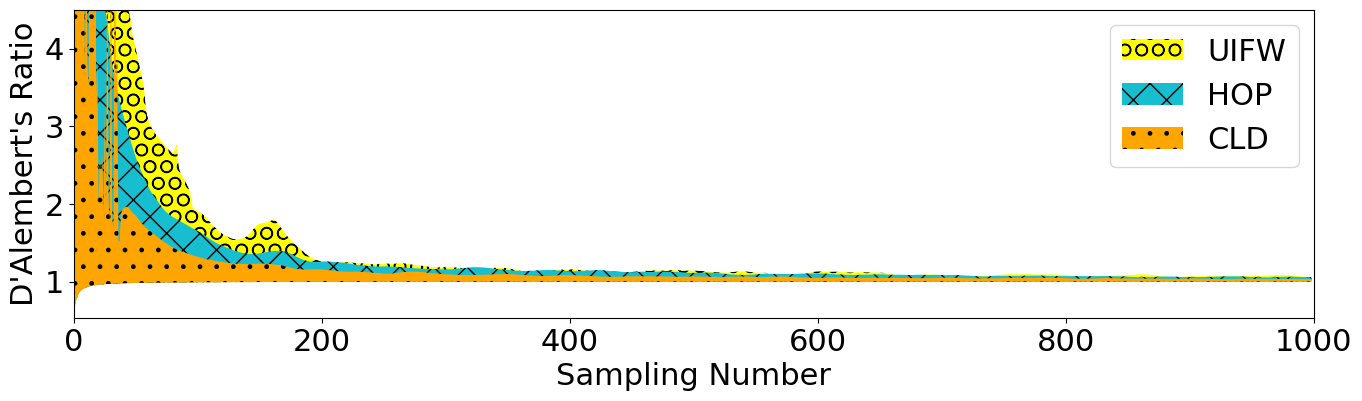

In [ ]:
import statsmodels.api as sm
plt.figure(figsize=(16,4))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font', **font)


frac = 0.04

# UIFW_ratio_test = valid_ratio_tests
X3 = np.concatenate(UIFW_ratio_test,axis=1)
mid3 = X3.mean(axis=1)
mid3_s = sm.nonparametric.lowess(mid3, list(range(len(mid))), frac = frac)
var = X3.var(axis=1)
upper = X3.max(axis=1)
upper_s = sm.nonparametric.lowess(upper, list(range(len(upper))), frac = frac)
lower = X3.min(axis=1)
plt.fill_between(list(range(len(lower))), lower, upper_s[:, 1], alpha=1, label="UIFW", facecolor='yellow', hatch='O')

# HOP_ratio_test = valid_ratio_tests
X = np.concatenate(HOP_ratio_test,axis=1)
mid = X.mean(axis=1)
mid_s = sm.nonparametric.lowess(mid, list(range(len(mid))), frac = frac)
var = X.var(axis=1)
upper = X.max(axis=1)
upper_s = sm.nonparametric.lowess(upper, list(range(len(upper))), frac = frac)
lower = X.min(axis=1)
plt.fill_between(list(range(len(lower))), lower, upper_s[:, 1], alpha=1, label="HOP", hatch='X', facecolor='tab:cyan')

# CLD_ratio_test = valid_ratio_tests
X2 = np.concatenate(CLD_ratio_test,axis=1)
mid2 = X2.mean(axis=1)
mid2_s = sm.nonparametric.lowess(mid2, list(range(len(mid))), frac = frac)
var = X2.var(axis=1)
upper = X2.max(axis=1)
upper_s = sm.nonparametric.lowess(upper, list(range(len(upper))), frac = frac)
lower = X2.min(axis=1)
plt.fill_between(list(range(len(lower))), lower, upper_s[:, 1], alpha=1, label="CLD", hatch='.', facecolor='orange')


# plt.plot(mid,linewidth=2,c='red', linestyle='dotted')
# plt.plot(mid2,linewidth=2,c='red', linestyle='dashed')
# plt.plot(mid3,linewidth=2,c='red', linestyle='dashdot')

plt.xlabel("Sampling Number")
plt.ylabel("D'Alembert's Ratio")
plt.ylim(min(lower), 4.5)
plt.xlim(0,1000)

plt.legend()
plt.show()

# SOTA

In [ ]:
noise_rate = 100
label_noise_rate = 0.0
epochs = 50
batch_size = 32
models = ['CNN_L']
repetitions = 1
restore_best = True
lr = 0.0001
beta_1 = 0.5

datasets = ['Dataset#2','UCI-HAR-Dataset']
for model in models:
    for problem in datasets:
        log_dir = f"/content/drive/MyDrive/[PhDPhase2]UncertaintyQauntification/log6/{problem}/"
        dataset = problems[problem]['dataset']
        n_classes = problems[problem]['n_classes']
        features = problems[problem]['features']
        sample_rate = problems[problem]['sample_rate']
        data_length_time = problems[problem]['data_length_time']
        n_h_block = problems[problem]['n_h_block']
        n_train_h_block = problems[problem]['n_train_h_block']
        n_valid_h_block = problems[problem]['n_valid_h_block']
        n_test_h_block = problems[problem]['n_test_h_block']
        h_moving_step = problems[problem]['h_moving_step']
        # train config index
        for tci in [0]:
            segments_time = problems[problem][model + '/segments_time']
            segments_overlap = problems[problem]['segments_overlaps']
            decision_time = problems[problem][model + '/decision_times']
            decision_overlap = problems[problem]['decision_overlaps']
            classifier = eval(model)(classes=n_classes,
                                     n_features=len(features),
                                     segments_size=int(segments_time * sample_rate),
                                     segments_overlap=segments_overlap,
                                     decision_size=int(decision_time * sample_rate),
                                     decision_overlap=decision_overlap,
                                     loss_metric=train_config[tci]["loss_metric"],
                                     loss_function=train_config[tci]["loss_function"],
                                     lr=lr, beta_1=beta_1)
            # cross-validation
            start = datetime.now()

            add_noise = noise_rate < 100
            data_blocks = [i for i in range(n_h_block)]
            n_vt = (n_valid_h_block + n_test_h_block)
            n_iteration = int((n_h_block - n_vt) / h_moving_step)
            i = 0
            training_container = data_blocks[0:i] + data_blocks[i + n_vt:n_h_block]
            train_blocks = training_container[:n_train_h_block]
            valid_blocks = data_blocks[i: i + n_valid_h_block]
            test_blocks = data_blocks[i + n_valid_h_block: i + n_vt]
            if problem == "Dataset#2":
                db = Dataset2(dataset,
                              sample_rate,
                              features=features,
                              window_time=segments_time,
                              window_overlap_percentage=segments_overlap,
                              decision_time=decision_time,
                              decision_overlap_percentage=decision_overlap,
                              add_noise=add_noise,
                              noise_rate=noise_rate,
                              label_noise_rate=label_noise_rate,
                              train_blocks=train_blocks,
                              valid_blocks=valid_blocks,
                              test_blocks=test_blocks,
                              data_length_time=data_length_time)
            elif problem == "UCI-HAR-Dataset":
                db = Dataset3(dataset,
                              sample_rate,
                              features=features,
                              window_time=segments_time,
                              window_overlap_percentage=segments_overlap,
                              decision_time=decision_time,
                              decision_overlap_percentage=decision_overlap,
                              add_noise=add_noise,
                              noise_rate=noise_rate,
                              label_noise_rate=label_noise_rate,
                              train_blocks=train_blocks,
                              valid_blocks=valid_blocks,
                              test_blocks=test_blocks,
                              data_length_time=data_length_time)
                
            db.load_data(n_classes=n_classes, method=classifier.get_data_arrangement())

            tm_statistics, dm_statistics, mm_statistics, org_statistics = h_block_analyzer(db_path=dataset,
                                                                                           sample_rate=sample_rate,
                                                                                           features=features,
                                                                                           n_classes=n_classes,
                                                                                           noise_rate=noise_rate,
                                                                                           label_noise_rate=label_noise_rate,
                                                                                           segments_time=segments_time,
                                                                                           segments_overlap=segments_overlap,
                                                                                           decision_time=decision_time,
                                                                                           decision_overlap=decision_overlap,
                                                                                           classifier=classifier,
                                                                                           epochs=epochs,
                                                                                           batch_size=batch_size,
                                                                                           data_length_time=data_length_time,
                                                                                           n_h_block=n_h_block,
                                                                                           n_train_h_block=n_train_h_block,
                                                                                           n_valid_h_block=n_valid_h_block,
                                                                                           n_test_h_block=n_test_h_block,
                                                                                           h_moving_step=h_moving_step,
                                                                                           monitor_metric=
                                                                                           train_config[tci][
                                                                                               "monitor_metric"],
                                                                                           monitor_mode=
                                                                                           train_config[tci][
                                                                                               "monitor_mode"],
                                                                                           restore_best=restore_best,
                                                                                           repetitions=repetitions)
            end = datetime.now()
            running_time = end - start
            for statistics, prediction_method in zip([tm_statistics, dm_statistics, mm_statistics, org_statistics],
                                                     ["Total MC", "Data MC", "Model MC", "Original"]):
                # Summarizing the results of cross-validation
                data = {}
                data['dataset'] = dataset
                data['prediction_method'] = prediction_method
                data['class'] = str(n_classes)
                loss_metric = train_config[tci]["loss_metric"]
                data['loss_metric'] = loss_metric if type(loss_metric) == str else loss_metric.__name__
                loss_function = train_config[tci]["loss_function"]
                data['loss_function'] = loss_function if type(loss_function) == str else loss_function.__name__
                data['lr'] = lr
                data['beta_1'] = beta_1
                data['monitor_metric'] = train_config[tci]["monitor_metric"]
                data['monitor_mode'] = train_config[tci]["monitor_mode"]
                data['restore_best'] = str(restore_best)
                data['features'] = str(features)
                data['sample_rate'] = str(sample_rate)
                data['noise_rate'] = str(noise_rate)
                data['label_noise_rate'] = str(label_noise_rate)
                data['epochs'] = str(epochs)
                data['batch_size'] = str(batch_size)
                data['data_length_time'] = str(data_length_time)
                data['repetitions'] = str(repetitions)
                data['n_h_block'] = str(n_h_block)
                data['n_train_h_block'] = str(n_train_h_block)
                data['n_valid_h_block'] = str(n_valid_h_block)
                data['n_test_h_block'] = str(n_test_h_block)
                data['h_moving_step'] = str(h_moving_step)
                data['segments_time'] = str(segments_time)
                data['segments_overlap'] = str(segments_overlap)
                data['inner_classifier'] = str(model)
                data['datetime'] = datetime.now().strftime("%Y:%m:%d %H:%M:%S")
                data['running_time'] = str(running_time.seconds) + " seconds"
                data['n_params'] = classifier.count_params()
                data['segments_time'] = timedelta(seconds=int(segments_time))
                data['segments_overlap'] = segments_overlap
                data['decision_time'] = timedelta(seconds=int(decision_time))
                data['decision_overlap'] = decision_overlap
                statistics_summary = {}
                for key in statistics.keys():
                    for inner_key in statistics[key].keys():
                        statistics_summary[key + '_' + inner_key + '_mean'] = np.average(statistics[key][inner_key])
                        statistics_summary[key + '_' + inner_key + '_std'] = np.std(statistics[key][inner_key])
                        statistics_summary[key + '_' + inner_key + '_max'] = np.max(statistics[key][inner_key])
                        statistics_summary[key + '_' + inner_key + '_min'] = np.min(statistics[key][inner_key])
                data.update(statistics_summary)
                # Save information
                save_result(log_dir=log_dir, data=data)

/content/drive/MyDrive/datasets/Dataset#2/train/Inertial Signals/train_acc_x.txt
/content/drive/MyDrive/datasets/Dataset#2/train/Inertial Signals/train_acc_y.txt
/content/drive/MyDrive/datasets/Dataset#2/train/Inertial Signals/train_acc_z.txt
/content/drive/MyDrive/datasets/Dataset#2/train/Inertial Signals/train_gyr_x.txt
/content/drive/MyDrive/datasets/Dataset#2/train/Inertial Signals/train_gyr_y.txt
/content/drive/MyDrive/datasets/Dataset#2/train/Inertial Signals/train_gyr_z.txt
/content/drive/MyDrive/datasets/Dataset#2/train/Inertial Signals/train_acc_x.txt
/content/drive/MyDrive/datasets/Dataset#2/train/Inertial Signals/train_acc_y.txt
/content/drive/MyDrive/datasets/Dataset#2/train/Inertial Signals/train_acc_z.txt
/content/drive/MyDrive/datasets/Dataset#2/train/Inertial Signals/train_gyr_x.txt
/content/drive/MyDrive/datasets/Dataset#2/train/Inertial Signals/train_gyr_y.txt
/content/drive/MyDrive/datasets/Dataset#2/train/Inertial Signals/train_gyr_z.txt
/content/drive/MyDrive/datas

2356/2356 [==============================] - ETA: 0s - loss: 0.7886 - accuracy: 0.7781

416/416 [==============================] - 1s 3ms/step
UN epoch 1: [ms_pesl: 0.000820] [mse: 0.000551] [accuracy: 0.994346] [f1: 0.993706]

Epoch 1: ms_pesl improved from inf to 0.00082, saving model to logs/checkpointss/20240116-141526[0]/[0]/weights-improvement-01-0.93.hdf5
2356/2356 [==============================] - 46s 18ms/step - loss: 0.7886 - accuracy: 0.7781 - val_loss: 0.2760 - val_accuracy: 0.9289 - ms_pesl: 8.1964e-04 - ms_uqm_mse: 5.5108e-04 - ms_uqm_acc: 0.9943 - ms_uqm_f1: 0.9937
Epoch 2/50
   6/2356 [..............................] - ETA: 23s - loss: 0.3044 - accuracy: 0.9115

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2351/2356 [============================>.] - ETA: 0s - loss: 0.2912 - accuracy: 0.9221

416/416 [==============================] - 1s 2ms/step
UN epoch 2: [ms_pesl: 0.000360] [mse: 0.000234] [accuracy: 0.997361] [f1: 0.997238]

Epoch 2: ms_pesl improved from 0.00082 to 0.00036, saving model to logs/checkpointss/20240116-141526[0]/[0]/weights-improvement-02-0.96.hdf5
2356/2356 [==============================] - 39s 17ms/step - loss: 0.2912 - accuracy: 0.9221 - val_loss: 0.1617 - val_accuracy: 0.9572 - ms_pesl: 3.5976e-04 - ms_uqm_mse: 2.3443e-04 - ms_uqm_acc: 0.9974 - ms_uqm_f1: 0.9972
Epoch 3/50
  14/2356 [..............................] - ETA: 19s - loss: 0.2903 - accuracy: 0.9174

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2356/2356 [==============================] - ETA: 0s - loss: 0.1932 - accuracy: 0.9469

416/416 [==============================] - 1s 3ms/step
UN epoch 3: [ms_pesl: 0.000223] [mse: 0.000133] [accuracy: 0.998115] [f1: 0.997765]

Epoch 3: ms_pesl improved from 0.00036 to 0.00022, saving model to logs/checkpointss/20240116-141526[0]/[0]/weights-improvement-03-0.97.hdf5
2356/2356 [==============================] - 42s 18ms/step - loss: 0.1932 - accuracy: 0.9469 - val_loss: 0.1288 - val_accuracy: 0.9652 - ms_pesl: 2.2287e-04 - ms_uqm_mse: 1.3335e-04 - ms_uqm_acc: 0.9981 - ms_uqm_f1: 0.9978
Epoch 4/50
  15/2356 [..............................] - ETA: 18s - loss: 0.1812 - accuracy: 0.9563

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2356/2356 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9595

416/416 [==============================] - 1s 2ms/step
UN epoch 4: [ms_pesl: 0.000101] [mse: 0.000066] [accuracy: 0.999246] [f1: 0.999224]

Epoch 4: ms_pesl improved from 0.00022 to 0.00010, saving model to logs/checkpointss/20240116-141526[0]/[0]/weights-improvement-04-0.97.hdf5
2356/2356 [==============================] - 40s 17ms/step - loss: 0.1461 - accuracy: 0.9595 - val_loss: 0.1052 - val_accuracy: 0.9739 - ms_pesl: 1.0148e-04 - ms_uqm_mse: 6.5671e-05 - ms_uqm_acc: 0.9992 - ms_uqm_f1: 0.9992
Epoch 5/50
  15/2356 [..............................] - ETA: 17s - loss: 0.1117 - accuracy: 0.9646

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2356/2356 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9679

416/416 [==============================] - 1s 2ms/step
UN epoch 5: [ms_pesl: 0.000085] [mse: 0.000049] [accuracy: 0.999246] [f1: 0.999224]

Epoch 5: ms_pesl improved from 0.00010 to 0.00008, saving model to logs/checkpointss/20240116-141526[0]/[0]/weights-improvement-05-0.98.hdf5
2356/2356 [==============================] - 40s 17ms/step - loss: 0.1153 - accuracy: 0.9679 - val_loss: 0.0877 - val_accuracy: 0.9773 - ms_pesl: 8.4606e-05 - ms_uqm_mse: 4.8798e-05 - ms_uqm_acc: 0.9992 - ms_uqm_f1: 0.9992
Epoch 6/50
  16/2356 [..............................] - ETA: 16s - loss: 0.0966 - accuracy: 0.9707

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2356/2356 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9724

416/416 [==============================] - 1s 2ms/step
UN epoch 6: [ms_pesl: 0.000058] [mse: 0.000040] [accuracy: 0.999623] [f1: 0.999639]

Epoch 6: ms_pesl improved from 0.00008 to 0.00006, saving model to logs/checkpointss/20240116-141526[0]/[0]/weights-improvement-06-0.98.hdf5
2356/2356 [==============================] - 40s 17ms/step - loss: 0.0978 - accuracy: 0.9724 - val_loss: 0.0802 - val_accuracy: 0.9798 - ms_pesl: 5.7514e-05 - ms_uqm_mse: 3.9610e-05 - ms_uqm_acc: 0.9996 - ms_uqm_f1: 0.9996
Epoch 7/50
   7/2356 [..............................] - ETA: 21s - loss: 0.0977 - accuracy: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2355/2356 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.9749

416/416 [==============================] - 1s 2ms/step
UN epoch 7: [ms_pesl: 0.000049] [mse: 0.000031] [accuracy: 0.999623] [f1: 0.999639]

Epoch 7: ms_pesl improved from 0.00006 to 0.00005, saving model to logs/checkpointss/20240116-141526[0]/[0]/weights-improvement-07-0.98.hdf5
2356/2356 [==============================] - 42s 18ms/step - loss: 0.0848 - accuracy: 0.9749 - val_loss: 0.0722 - val_accuracy: 0.9824 - ms_pesl: 4.9131e-05 - ms_uqm_mse: 3.1226e-05 - ms_uqm_acc: 0.9996 - ms_uqm_f1: 0.9996
Epoch 8/50
  15/2356 [..............................] - ETA: 18s - loss: 0.0667 - accuracy: 0.9812

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2355/2356 [============================>.] - ETA: 0s - loss: 0.0732 - accuracy: 0.9787

416/416 [==============================] - 1s 3ms/step
UN epoch 8: [ms_pesl: 0.000022] [mse: 0.000022] [accuracy: 1.000000] [f1: 1.000000]

Epoch 8: ms_pesl improved from 0.00005 to 0.00002, saving model to logs/checkpointss/20240116-141526[0]/[0]/weights-improvement-08-0.98.hdf5
2356/2356 [==============================] - 43s 18ms/step - loss: 0.0732 - accuracy: 0.9787 - val_loss: 0.0708 - val_accuracy: 0.9826 - ms_pesl: 2.1588e-05 - ms_uqm_mse: 2.1588e-05 - ms_uqm_acc: 1.0000 - ms_uqm_f1: 1.0000
Epoch 9/50
  15/2356 [..............................] - ETA: 18s - loss: 0.0612 - accuracy: 0.9833

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2354/2356 [============================>.] - ETA: 0s - loss: 0.0650 - accuracy: 0.9804

416/416 [==============================] - 1s 2ms/step
UN epoch 9: [ms_pesl: 0.000047] [mse: 0.000029] [accuracy: 0.999623] [f1: 0.999639]

Epoch 9: ms_pesl did not improve from 0.00002
2356/2356 [==============================] - 41s 17ms/step - loss: 0.0650 - accuracy: 0.9805 - val_loss: 0.0634 - val_accuracy: 0.9856 - ms_pesl: 4.7249e-05 - ms_uqm_mse: 2.9344e-05 - ms_uqm_acc: 0.9996 - ms_uqm_f1: 0.9996
Epoch 10/50
2352/2356 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.9822

416/416 [==============================] - 1s 2ms/step
UN epoch 10: [ms_pesl: 0.000083] [mse: 0.000047] [accuracy: 0.999246] [f1: 0.999224]

Epoch 10: ms_pesl did not improve from 0.00002
2356/2356 [==============================] - 43s 18ms/step - loss: 0.0597 - accuracy: 0.9822 - val_loss: 0.0636 - val_accuracy: 0.9847 - ms_pesl: 8.2578e-05 - ms_uqm_mse: 4.6770e-05 - ms_uqm_acc: 0.9992 - ms_uqm_f1:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2355/2356 [============================>.] - ETA: 0s - loss: 0.0452 - accuracy: 0.9864

416/416 [==============================] - 1s 2ms/step
UN epoch 13: [ms_pesl: 0.000011] [mse: 0.000011] [accuracy: 1.000000] [f1: 1.000000]

Epoch 13: ms_pesl improved from 0.00001 to 0.00001, saving model to logs/checkpointss/20240116-141526[0]/[0]/weights-improvement-13-0.99.hdf5
2356/2356 [==============================] - 42s 18ms/step - loss: 0.0452 - accuracy: 0.9864 - val_loss: 0.0577 - val_accuracy: 0.9868 - ms_pesl: 1.1448e-05 - ms_uqm_mse: 1.1448e-05 - ms_uqm_acc: 1.0000 - ms_uqm_f1: 1.0000
Epoch 14/50
  15/2356 [..............................] - ETA: 17s - loss: 0.0373 - accuracy: 0.9854

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2352/2356 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.9876

416/416 [==============================] - 1s 3ms/step
UN epoch 14: [ms_pesl: 0.000014] [mse: 0.000014] [accuracy: 1.000000] [f1: 1.000000]

Epoch 14: ms_pesl did not improve from 0.00001
2356/2356 [==============================] - 42s 18ms/step - loss: 0.0397 - accuracy: 0.9876 - val_loss: 0.0585 - val_accuracy: 0.9877 - ms_pesl: 1.4422e-05 - ms_uqm_mse: 1.4422e-05 - ms_uqm_acc: 1.0000 - ms_uqm_f1: 1.0000
Epoch 15/50
2353/2356 [============================>.] - ETA: 0s - loss: 0.0377 - accuracy: 0.9882

416/416 [==============================] - 1s 2ms/step
UN epoch 15: [ms_pesl: 0.000009] [mse: 0.000009] [accuracy: 1.000000] [f1: 1.000000]

Epoch 15: ms_pesl improved from 0.00001 to 0.00001, saving model to logs/checkpointss/20240116-141526[0]/[0]/weights-improvement-15-0.99.hdf5
2356/2356 [==============================] - 40s 17ms/step - loss: 0.0377 - accuracy: 0.9882 - val_loss: 0.0523 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2356/2356 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.9892

416/416 [==============================] - 1s 2ms/step
UN epoch 16: [ms_pesl: 0.000050] [mse: 0.000032] [accuracy: 0.999623] [f1: 0.999585]

Epoch 16: ms_pesl did not improve from 0.00001
2356/2356 [==============================] - 41s 17ms/step - loss: 0.0339 - accuracy: 0.9892 - val_loss: 0.0542 - val_accuracy: 0.9877 - ms_pesl: 4.9778e-05 - ms_uqm_mse: 3.1874e-05 - ms_uqm_acc: 0.9996 - ms_uqm_f1: 0.9996
Epoch 17/50
2353/2356 [============================>.] - ETA: 0s - loss: 0.0321 - accuracy: 0.9896

416/416 [==============================] - 1s 3ms/step
UN epoch 17: [ms_pesl: 0.000016] [mse: 0.000016] [accuracy: 1.000000] [f1: 1.000000]

Epoch 17: ms_pesl did not improve from 0.00001
2356/2356 [==============================] - 41s 17ms/step - loss: 0.0321 - accuracy: 0.9896 - val_loss: 0.0550 - val_accuracy: 0.9876 - ms_pesl: 1.5703e-05 - ms_uqm_mse: 1.5703e-05 - ms_uqm_acc: 1.0000 - ms_uqm_f

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2353/2356 [============================>.] - ETA: 0s - loss: 0.0271 - accuracy: 0.9908

416/416 [==============================] - 1s 2ms/step
UN epoch 20: [ms_pesl: 0.000018] [mse: 0.000018] [accuracy: 1.000000] [f1: 1.000000]

Epoch 20: ms_pesl did not improve from 0.00001
2356/2356 [==============================] - 39s 17ms/step - loss: 0.0271 - accuracy: 0.9908 - val_loss: 0.0534 - val_accuracy: 0.9886 - ms_pesl: 1.7985e-05 - ms_uqm_mse: 1.7985e-05 - ms_uqm_acc: 1.0000 - ms_uqm_f1: 1.0000
Epoch 21/50
2354/2356 [============================>.] - ETA: 0s - loss: 0.0251 - accuracy: 0.9920

416/416 [==============================] - 1s 2ms/step
UN epoch 21: [ms_pesl: 0.000014] [mse: 0.000014] [accuracy: 1.000000] [f1: 1.000000]

Epoch 21: ms_pesl did not improve from 0.00001
2356/2356 [==============================] - 41s 18ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.0521 - val_accuracy: 0.9893 - ms_pesl: 1.4392e-05 - ms_uqm_mse: 1.4392e-05 - ms_uqm_acc: 1.0000 - ms_uqm_f

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2353/2356 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.9941

416/416 [==============================] - 1s 3ms/step
UN epoch 30: [ms_pesl: 0.000014] [mse: 0.000014] [accuracy: 1.000000] [f1: 1.000000]

Epoch 30: ms_pesl did not improve from 0.00001
2356/2356 [==============================] - 40s 17ms/step - loss: 0.0176 - accuracy: 0.9941 - val_loss: 0.0546 - val_accuracy: 0.9896 - ms_pesl: 1.4076e-05 - ms_uqm_mse: 1.4076e-05 - ms_uqm_acc: 1.0000 - ms_uqm_f1: 1.0000
Epoch 31/50
2354/2356 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9951

416/416 [==============================] - 1s 2ms/step
UN epoch 31: [ms_pesl: 0.000016] [mse: 0.000016] [accuracy: 1.000000] [f1: 1.000000]

Epoch 31: ms_pesl did not improve from 0.00001
2356/2356 [==============================] - 38s 16ms/step - loss: 0.0153 - accuracy: 0.9951 - val_loss: 0.0525 - val_accuracy: 0.9899 - ms_pesl: 1.6014e-05 - ms_uqm_mse: 1.6014e-05 - ms_uqm_acc: 1.0000 - ms_uqm_f

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




309/309 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

OR Results: Classifier:CNN_L Test(Core):0.0011 Test(MS)/acc:0.9822 Test(MS)/f1:0.9594
UN Results: Classifier:CNN_L Test(Core):0.0011 Test(MS)/acc:0.9852 Test(MS)/f1:0.9681
OR Results: Classifier:CNN_L Test(Core):0.0011 Test(MV)/acc:0.9822 Test(MV)/f1:0.9603
UN Results: Classifier:CNN_L Test(Core):0.0011 Test(MV)/acc:0.9852 Test(MV)/f1:0.9681
final_tc_statistics {'Core': {'pesl': [0.0046114526], 'mse': [0.0029225849132529223], 'accuracy': [0.001114262560777958], 'precision': [0.0008485987418674452], 'recall': [0.002050032455986809], 'f1': [0.001010011500065772]}, 'MV': {'pesl': [0.0022667528], 'esl': [0.001493609376706044], 'll': [0.25090285468063256], 'accuracy': [0.9837232960325534], 'precision': [0.9830268221175056], 'recall': [0.9651282051282051], 'f1': [0.9643976128600279]}, 'MS': {'pesl': [0.0021768906], 'esl': [0.0014037473515146506], 'll': [0.20669922533810034], 'accuracy': [0.9837232960325534], 'precision': [0.9832182656524762], 'recall': [0.9644444444444444], 'f1': [0.96329840

# Visualization of Similarity

In [ ]:
noise_rate = 100
label_noise_rate = 0.0
models = ['CNN_L']

# 'DriverIdentification','ConfLongDemo_JSI','Healthy_Older_People','Motor_Failure_Time','Power_consumption','PRSA2017','RSSI','User_Identification_From_Walking','WISDM'
datasets = ['ConfLongDemo_JSI']
for model in models:
    for problem in datasets:
        log_dir = f"/content/drive/MyDrive/[PhDPhase2]UncertaintyQauntification/log5/{problem}/classic/"
        dataset_path = problems[problem]['dataset']
        n_classes = problems[problem]['n_classes']
        features = problems[problem]['features']
        sample_rate = problems[problem]['sample_rate']
        data_length_time = problems[problem]['data_length_time']
        n_h_block = problems[problem]['n_h_block']
        n_train_h_block = problems[problem]['n_train_h_block']
        n_valid_h_block = problems[problem]['n_valid_h_block']
        n_test_h_block = problems[problem]['n_test_h_block']
        h_moving_step = problems[problem]['h_moving_step']
        segments_times = [4]
        subsets = ['walking', 'lying', 'sitting', 'standing up from lying']
        datasets = []
        for dataset_i, set_ in enumerate(subsets):
            for segments_time in segments_times:
                segments_overlap = problems[problem]['segments_overlaps']
                decision_time = problems[problem][model + '/decision_times']
                decision_overlap = problems[problem]['decision_overlaps']
                classifier = eval(model)(classes=n_classes,
                                         n_features=len(features),
                                         segments_size=int(segments_time * sample_rate),
                                         segments_overlap=segments_overlap,
                                         decision_size=int(decision_time * sample_rate),
                                         decision_overlap=decision_overlap,
                                         loss_metric=train_config[0]["loss_metric"],
                                         loss_function=train_config[0]["loss_function"])

                add_noise = noise_rate < 100
                data_blocks = [i for i in range(n_h_block)]
                n_vt = (n_valid_h_block + n_test_h_block)
                n_iteration = int((n_h_block - n_vt) / h_moving_step)
                i = 0
                training_container = data_blocks[0:i] + data_blocks[i + n_vt:n_h_block]
                train_blocks = training_container[:n_train_h_block]
                valid_blocks = data_blocks[i: i + n_valid_h_block]
                test_blocks = data_blocks[i + n_valid_h_block: i + n_vt]

                datasets.append(Dataset(dataset_path,
                                        sample_rate,
                                        features=features,
                                        window_time=segments_time,
                                        window_overlap_percentage=segments_overlap,
                                        decision_time=decision_time,
                                        decision_overlap_percentage=decision_overlap,
                                        add_noise=add_noise,
                                        noise_rate=noise_rate,
                                        label_noise_rate=label_noise_rate,
                                        train_blocks=train_blocks,
                                        valid_blocks=valid_blocks,
                                        test_blocks=test_blocks,
                                        data_length_time=data_length_time))
                datasets[dataset_i].load_data(n_classes=n_classes, method=classifier.get_data_arrangement(),
                                              subset=[set_], read_cache=False, random_selection=False)


./ConfLongDemo_JSI/segments/method: 3d/noise: 100/n_classes:5/wl: 120/wo: 90/dl: 1800/do: 0/train: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]/valid: [0]/test: [1]/
class:     C, data size: 0:03:37, selected data size: 0:03:37
class:     E, data size: 0:05:47, selected data size: 0:05:47
class:     A, data size: 0:02:01, selected data size: 0:02:01
class:     D, data size: 0:03:40, selected data size: 0:03:40
class:     B, data size: 0:03:03, selected data size: 0:03:03
segmenting data with 28249 points
making 924 segments
segmenting data with 2173 points
making 56 segments
segmenting data with 2173 points
making 56 segments
./ConfLongDemo_JSI/segments/method: 3d/noise: 100/n_classes:5/wl: 120/wo: 90/dl: 1800/do: 0/train: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]/valid: [0]/test: [1]/
class:     C, data size: 0:05:32, selected data size: 0:05:32
class:     E, data size: 0:06:49, selected data size: 0:06:49
class:     A, data size: 0:05:53, selected data size: 0:05:53
class:     D, 

In [ ]:
X1_x = datasets[0].X_train[:,0,:,0]
X1_y = datasets[0].X_train[:,0,:,1]
X1_z = datasets[0].X_train[:,0,:,2]

X2_x = datasets[1].X_train[:,0,:,0]
X2_y = datasets[1].X_train[:,0,:,1]
X2_z = datasets[1].X_train[:,0,:,2]

X3_x = datasets[2].X_train[:,0,:,0]
X3_y = datasets[2].X_train[:,0,:,1]
X3_z = datasets[2].X_train[:,0,:,2]

X4_x = datasets[3].X_train[:,0,:,0]
X4_y = datasets[3].X_train[:,0,:,1]
X4_z = datasets[3].X_train[:,0,:,2]

y1 = np.full((len(X1_x)), 0)
y2 = np.full((len(X2_x)), 1)
y3 = np.full((len(X3_x)), 2)
y4 = np.full((len(X4_x)), 3)

yclass1 = datasets[0].y_train
yclass2 = datasets[1].y_train
yclass3 = datasets[2].y_train
yclass4 = datasets[3].y_train

print("X1", np.shape(X1_x), np.shape(X1_y), np.shape(X1_z))
print("X2", np.shape(X2_x), np.shape(X2_y), np.shape(X2_z))
print("X3", np.shape(X3_x), np.shape(X3_y), np.shape(X3_z))
print("X4", np.shape(X4_x), np.shape(X4_y), np.shape(X4_z))
print("y", np.shape(y1), np.shape(y2), np.shape(y3), np.shape(y4))

from sklearn.utils import shuffle
X1_x, X1_y, X1_z, yclass1 = shuffle(X1_x, X1_y, X1_z, yclass1, random_state=0)
X2_x, X2_y, X2_z, yclass2 = shuffle(X2_x, X2_y, X2_z, yclass2, random_state=0)
X3_x, X3_y, X3_z, yclass3 = shuffle(X3_x, X3_y, X3_z, yclass3, random_state=0)
X4_x, X4_y, X4_z, yclass4 = shuffle(X4_x, X4_y, X4_z, yclass4, random_state=0)

K = -1
X_x_all = np.concatenate((X1_x[:K], X2_x[:K], X3_x[:K], X4_x[:K]), axis=0)
X_y_all = np.concatenate((X1_y[:K], X2_y[:K], X3_y[:K], X4_y[:K]), axis=0)
X_z_all = np.concatenate((X1_z[:K], X2_z[:K], X3_z[:K], X4_z[:K]), axis=0)
yall = np.concatenate((y1[:K], y2[:K], y3[:K], y4[:K]), axis=0)
yclassall = np.concatenate((yclass1[:K], yclass2[:K], yclass3[:K], yclass4[:K]), axis=0)

print(np.shape(X_x_all), np.shape(X_y_all), np.shape(X_z_all))
print(np.shape(yall))
print(np.shape(yclassall))

X1 (924, 120) (924, 120) (924, 120)
X2 (1553, 120) (1553, 120) (1553, 120)
X3 (766, 120) (766, 120) (766, 120)
X4 (510, 120) (510, 120) (510, 120)
y (924,) (1553,) (766,) (510,)
(3749, 120) (3749, 120) (3749, 120)
(3749,)
(3749,)


In [ ]:
from dtaidistance import dtw

similarity_matrix1 = np.full((X_x_all.shape[0], X_x_all.shape[0]), 0)
similarity_matrix2 = np.full((X_x_all.shape[0], X_x_all.shape[0]), 0)
similarity_matrix3 = np.full((X_x_all.shape[0], X_x_all.shape[0]), 0)

for i in range(X_x_all.shape[0]):
    for j in range(i+1, X_x_all.shape[0]):
        dtw_ = dtw.distance(X_x_all[i], X_x_all[j])
        similarity_matrix1[i][j] = dtw_
        similarity_matrix1[j][i] = dtw_
    print(i, "/", X_x_all.shape[0])

In [ ]:
def plot_tsne(X_embedded, label):
    df_subset = pd.DataFrame()
    df_subset['tsne1'] = X_embedded[:, 0]
    df_subset['tsne2'] = X_embedded[:, 1]

    plt.figure(figsize=(8, 4))
    g1 = sns.scatterplot(
        x="tsne1", y="tsne2",
        hue=label,
        palette="Set1",
        data=df_subset,
        legend='brief',
        s=15
    )
    sns.move_legend(g1, "lower left", bbox_to_anchor=(0, 1), ncol=5)
    g1.set(xlabel=None)
    g1.set(xticklabels=[])
    g1.set(ylabel=None)
    g1.set(yticklabels=[])
    g1.set_frame_on(False)
    g1.tick_params(left=False, bottom=False)
    plt.show()

In [ ]:
X_all = np.concatenate((X_x_all, X_y_all, X_z_all), axis=1)
X_all.shape

(3749, 360)

In [ ]:
def similarity_fun(X1,X2):
    m = dtw.distance(X1,X2)
    return (- 1 / similarity_matrix.max()) * m + 1

In [ ]:
X = X_all
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(X)

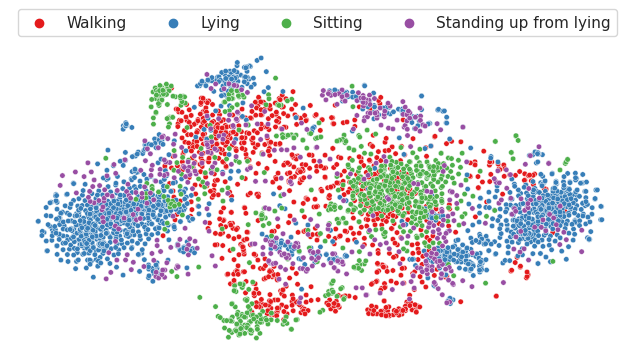

In [ ]:
label_dic = {0:'Walking', 1:'Lying', 2:'Sitting', 3:'Standing up from lying'}
labels_data = [label_dic[i] for i in yall]

plot_tsne(X_embedded, labels_data)

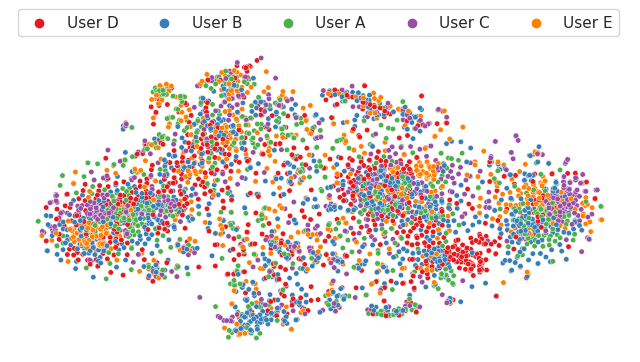

In [ ]:
label_dic = {0:'User A', 1:'User B', 2:'User C', 3:'User D', 4:'User E'}
labels_data = [label_dic[i] for i in yclassall]

plot_tsne(X_embedded, labels_data)

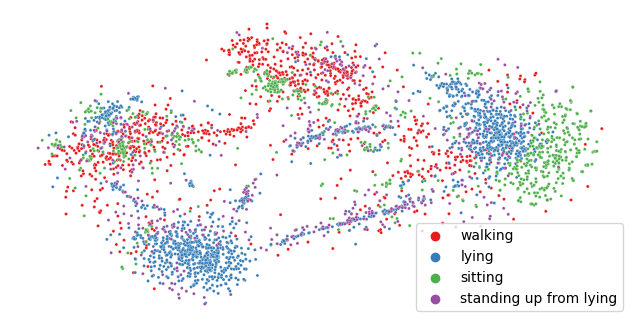

In [ ]:
label_dic = {0:'walking', 1:'lying', 2:'sitting', 3:'standing up from lying'}
labels_data = [label_dic[i] for i in yall]

plot_tsne(X_embedded, labels_data)

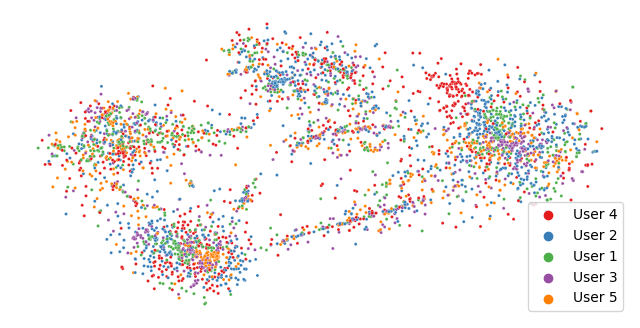

In [ ]:
label_dic = {0:'User 1', 1:'User 2', 2:'User 3', 3:'User 4', 4:'User 5'}
labels_data = [label_dic[i] for i in yclassall]

plot_tsne(X_embedded, labels_data)

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=4bfa24b1c686f12751ae859069c9ff806f20fdfe8e1df2827623e0a8ad1ecd8c
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
import umap
reducer = umap.UMAP(random_state=42)

In [ ]:
embedding = reducer.fit_transform(X)
embedding.shape

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(3749, 2)

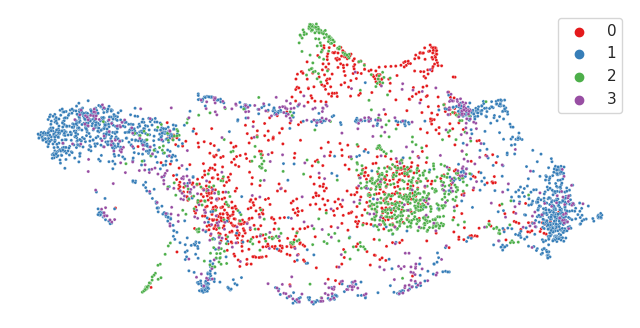

In [ ]:
plot_tsne(embedding, yall)

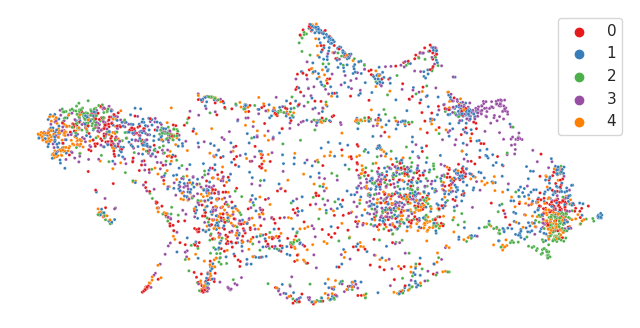

In [ ]:
plot_tsne(embedding, yclassall)

# Measure Similarity

./Healthy_Older_People/segments/method: 3d/noise: 100/wl: 4/wo: 3/dl: 120/do: 0/train: [6, 7, 8, 9, 10, 11, 12, 13, 14]/valid: [0]/test: [1, 2, 3, 4, 5]/
class: d1p47M, data size: 0:46:58, selected data size: 0:46:58
class: d1p53F, data size: 1:16:03, selected data size: 1:16:03
class: d1p43M, data size: 0:40:27, selected data size: 0:40:27
class: d1p48M, data size: 0:36:24, selected data size: 0:36:24
class: d1p49F, data size: 0:47:56, selected data size: 0:47:56
class: d1p50F, data size: 1:17:18, selected data size: 1:17:18
class: d1p52F, data size: 0:27:28, selected data size: 0:27:28
class: d1p42M, data size: 0:34:20, selected data size: 0:34:20
class: d1p45M, data size: 0:55:39, selected data size: 0:55:39
class: d1p46M, data size: 0:42:22, selected data size: 0:42:22
class: d1p44M, data size: 0:52:19, selected data size: 0:52:19
class: d1p51F, data size: 0:50:44, selected data size: 0:50:44
segmenting data with 20997 points
making 20961 segments
segmenting data with 2333 points
m

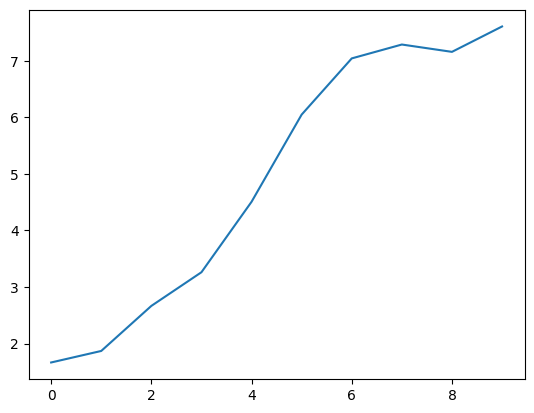

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from dtaidistance import dtw

noise_rate = 100
label_noise_rate = 0.0
epochs = 20
batch_size = 32
models = ['CNN_L']
repetitions = 5
restore_best = True

datasets = ['Healthy_Older_People']
for model in models:
    for problem in datasets:
        log_dir = f"/content/drive/MyDrive/[PhDPhase2]UncertaintyQauntification/log5/{problem}/classic/"
        dataset_path = problems[problem]['dataset']
        n_classes = problems[problem]['n_classes']
        features = problems[problem]['features']
        sample_rate = problems[problem]['sample_rate']
        data_length_time = problems[problem]['data_length_time']
        n_h_block = problems[problem]['n_h_block']
        n_train_h_block = problems[problem]['n_train_h_block']
        n_valid_h_block = problems[problem]['n_valid_h_block']
        n_test_h_block = problems[problem]['n_test_h_block']
        h_moving_step = problems[problem]['h_moving_step']
        sims = []
        for segments_time in [4, 5, 10, 15, 30, 60, 90, 120, 150, 180]:
            segments_overlap = problems[problem]['segments_overlaps']
            decision_time = problems[problem][model + '/decision_times']
            decision_overlap = problems[problem]['decision_overlaps']
            classifier = eval(model)(classes=n_classes,
                                     n_features=len(features),
                                     segments_size=int(segments_time * sample_rate),
                                     segments_overlap=segments_overlap,
                                     decision_size=int(decision_time * sample_rate),
                                     decision_overlap=decision_overlap,
                                     loss_metric=train_config[0]["loss_metric"],
                                     loss_function=train_config[0]["loss_function"])

            add_noise = noise_rate < 100
            data_blocks = [i for i in range(n_h_block)]
            n_vt = (n_valid_h_block + n_test_h_block)
            n_iteration = int((n_h_block - n_vt) / h_moving_step)
            i = 0
            training_container = data_blocks[0:i] + data_blocks[i + n_vt:n_h_block]
            train_blocks = training_container[:n_train_h_block]
            valid_blocks = data_blocks[i: i + n_valid_h_block]
            test_blocks = data_blocks[i + n_valid_h_block: i + n_vt]

            dataset = Dataset(dataset_path,
                              sample_rate,
                              features=features,
                              window_time=segments_time,
                              window_overlap_percentage=segments_overlap,
                              decision_time=decision_time,
                              decision_overlap_percentage=decision_overlap,
                              add_noise=add_noise,
                              noise_rate=noise_rate,
                              label_noise_rate=label_noise_rate,
                              train_blocks=train_blocks,
                              valid_blocks=valid_blocks,
                              test_blocks=test_blocks,
                              data_length_time=data_length_time)
            dataset.load_data(n_classes=n_classes, method=classifier.get_data_arrangement())

            data_shape = np.shape(dataset.X_train)
            sum_sim = 0
            iter = 0
            for i in range(dataset.X_valid.shape[0]):
                for j in range(i + 1, dataset.X_valid.shape[0]):
                    # sum_sim = sum_sim + np.diag(cosine_similarity(dataset.X_train[i][0].transpose(), dataset.X_train[j][0].transpose())).mean()
                    # sum_sim = sum_sim + np.diag(pairwise_distances(dataset.X_train[i][0].transpose(), dataset.X_train[j][0].transpose(),n_jobs=-1)).mean()

                    dtw_ = dtw.distance(dataset.X_valid[i][0].transpose()[0], dataset.X_valid[j][0].transpose()[0])
                    dtw_ = dtw_ + dtw.distance(dataset.X_valid[i][0].transpose()[1],
                                               dataset.X_valid[j][0].transpose()[1])
                    dtw_ = dtw_ + dtw.distance(dataset.X_valid[i][0].transpose()[2],
                                               dataset.X_valid[j][0].transpose()[2])
                    sum_sim = sum_sim + (dtw_ / 3)

                    iter = iter + 1
            mean_sim = sum_sim / iter
            sims.append(mean_sim)
            print(segments_time, mean_sim)
        plt.plot(sims)
        plt.show()